# 第 0 步：Notebook 基础配置

In [1]:
import os, math, time, random
from dataclasses import dataclass
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from dataclasses import dataclass
from pathlib import Path
import html
import random

# 可选：画图
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

# 第 1 步：超参数与目录

In [2]:
@dataclass
class CFG:
    data_dir: str = r"./wmt_data"
    csv_file: str = "wmt_zh_en_training_corpus.csv"

    # 从同一个文件切分
    train_ratio: float = 0.98
    valid_ratio: float = 0.01
    test_ratio:  float = 0.01
    seed: int = 42

cfg = CFG()
csv_path = Path(cfg.data_dir) / cfg.csv_file
csv_path


WindowsPath('wmt_data/wmt_zh_en_training_corpus.csv')

# 第 2 步：先做一个“文件存在性检查 + 抽样查看”的小工具

In [1]:
def preview_file(path, n=5):
    path = Path(path)
    print("==>", path.resolve())
    if not path.exists():
        print("❌ 文件不存在")
        return
    with path.open("r", encoding="utf-8") as f:
        for i in range(n):
            line = f.readline()
            if not line:
                break
            print(f"[{i}] {line.rstrip()[:220]}")

preview_file(csv_path, n=5)


NameError: name 'csv_path' is not defined

# 第 3 步：稳健 CSV 解析器

In [4]:
def load_pairs_from_csv_first_comma(path: str | Path, max_rows: int | None = None):
    path = Path(path)
    pairs = []

    with path.open("r", encoding="utf-8") as f:
        for line_idx, line in enumerate(f):
            line = line.strip()
            if not line:
                continue

            # 跳过表头：0,1 或 "0","1"
            if line_idx == 0:
                head = line.replace('"', "").replace(" ", "")
                if head == "0,1":
                    continue

            # 找第一个逗号
            k = line.find(",")
            if k == -1:
                continue

            src = line[:k].strip()
            tgt = line[k+1:].strip()

            # 去两侧引号（若有）
            if len(src) >= 2 and src[0] == '"' and src[-1] == '"':
                src = src[1:-1].strip()
            if len(tgt) >= 2 and tgt[0] == '"' and tgt[-1] == '"':
                tgt = tgt[1:-1].strip()

            # 反转义：&apos; &quot; 等
            src = html.unescape(src)
            tgt = html.unescape(tgt)

            if src and tgt:
                pairs.append((src, tgt))

            if max_rows is not None and len(pairs) >= max_rows:
                break

    return pairs

pairs_all = load_pairs_from_csv_first_comma(csv_path, max_rows=None)
len(pairs_all), pairs_all[0]


(24752356,
 ('表演 的 明星 是 X 女孩 团队 — — 由 一对 具有 天才 技艺 的 艳舞 女孩 们 组成 ， 其中 有些 人 受过 专业 的 训练 。',
  'the show stars the X Girls - a troupe of talented topless dancers , some of whom are classically trained .'))

# 第 4 步 数据集划分

In [5]:
def split_train_valid_test(pairs, train_ratio=0.98, valid_ratio=0.01, test_ratio=0.01, seed=42):
    assert abs((train_ratio + valid_ratio + test_ratio) - 1.0) < 1e-6, "比例之和必须为 1"
    pairs = list(pairs)
    rnd = random.Random(seed)
    rnd.shuffle(pairs)

    n = len(pairs)
    n_train = int(n * train_ratio)
    n_valid = int(n * valid_ratio)
    # 剩下的都给 test，避免四舍五入导致总数不一致
    n_test  = n - n_train - n_valid

    train_pairs = pairs[:n_train]
    valid_pairs = pairs[n_train:n_train+n_valid]
    test_pairs  = pairs[n_train+n_valid:]

    return train_pairs, valid_pairs, test_pairs

train_pairs, valid_pairs, test_pairs = split_train_valid_test(
    pairs_all,
    train_ratio=cfg.train_ratio,
    valid_ratio=cfg.valid_ratio,
    test_ratio=cfg.test_ratio,
    seed=cfg.seed
)

len(train_pairs), len(valid_pairs), len(test_pairs), train_pairs[0]


(24257308,
 247523,
 247525,
 ('这个 镇子 崛起 在 中西部 的 这块 地方 已经 有 很 久 了 .',
  'the town has existed for a long time in this part of the Mid - West .'))

# 第 5 步 做一个 Dataset / DataLoader

In [6]:
class TranslationPairsDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        return {"src_text": src, "tgt_text": tgt}

def collate_text_only(batch):
    return {
        "src_text": [x["src_text"] for x in batch],
        "tgt_text": [x["tgt_text"] for x in batch],
    }

train_ds = TranslationPairsDataset(train_pairs)
valid_ds = TranslationPairsDataset(valid_pairs)
test_ds  = TranslationPairsDataset(test_pairs)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_text_only)

batch = next(iter(train_loader))
print("SRC[0]:", batch["src_text"][0])
print("TGT[0]:", batch["tgt_text"][0])
print(batch["tgt_text"][31])
print(batch["src_text"][31])

SRC[0]: ( b ) 1994 年 3 月 24 日 ， 一名 不 知名 攻击者 向 《 Antarakum 》 报社 的 办事处 扔 手榴弹 ;
TGT[0]: ( b ) The grenade attack on 24 March 1994 on the office of the newspaper Antarakum by unknown attackers ;
Jordan supported the initiative of the League of Arab States to achieve a just peace based on the twoState solution .
约旦 支持 阿拉伯国家联盟 的 倡议 ， 在 两个 国家 解决方案 的 基础 上 实现 公正 的 和平 。


# Cell 6.1：特殊符号 + 空格分词器

In [7]:
from collections import Counter

PAD = "<pad>"
UNK = "<unk>"
BOS = "<bos>"
EOS = "<eos>"

# <pad>	填充标记	0	模型输入要求固定长度，短句子末尾补<pad>（如 ["我","爱","编程","<pad>"]）
# <unk>	未知标记	1	遇到词汇表外的词时替换（如生僻词、拼写错误词），避免编码失败
# <bos>	句子开始标记	2	目标文本开头添加（如翻译时，模型输入<bos>生成目标句）
# <eos>	句子结束标记	3	目标文本结尾添加（告诉模型 “句子生成完毕”）
SPECIAL_TOKENS = [PAD, UNK, BOS, EOS]
PAD_ID, UNK_ID, BOS_ID, EOS_ID = 0, 1, 2, 3

def tokenize_space(text: str):
    # 你的数据已经用空格切好词了
    # 额外做一下 strip，避免空 token
    return [t for t in text.strip().split() if t]


# Cell 6.2：从训练集构建 vocab（支持截断到 top-K）

In [8]:
def build_vocab(pairs, max_vocab=50000, min_freq=2, side="src"):
    """
    side: "src" 或 "tgt"
    """
    assert side in ("src", "tgt")
    counter = Counter()

    for src, tgt in pairs:
        text = src if side == "src" else tgt
        tokens = tokenize_space(text)
        counter.update(tokens)

    # 过滤低频
    items = [(tok, c) for tok, c in counter.items() if c >= min_freq]
    # 按频率排序
    items.sort(key=lambda x: x[1], reverse=True)

    # 截断 vocab
    if max_vocab is not None:
        items = items[: max(0, max_vocab - len(SPECIAL_TOKENS))]

    itos = SPECIAL_TOKENS + [tok for tok, _ in items]
    stoi = {tok: i for i, tok in enumerate(itos)}
    return stoi, itos, counter

# 先用一个较稳的词表大小（你后面可改）
max_vocab = 60000
min_freq  = 2

src_stoi, src_itos, src_counter = build_vocab(train_pairs, max_vocab=max_vocab, min_freq=min_freq, side="src")
tgt_stoi, tgt_itos, tgt_counter = build_vocab(train_pairs, max_vocab=max_vocab, min_freq=min_freq, side="tgt")

len(src_itos), len(tgt_itos), src_itos[:10], tgt_itos[:10]


(60000,
 60000,
 ['<pad>', '<unk>', '<bos>', '<eos>', '的', '，', '。', '和', '在', '.'],
 ['<pad>', '<unk>', '<bos>', '<eos>', 'the', ',', 'of', '.', 'and', 'to'])

# Cell 6.3：词表覆盖率（看看 OOV 比例，判断 vocab 是否够大）

In [9]:
def oov_rate(pairs, stoi, side="src", max_samples=20000):
    import random
    rnd = random.Random(42)
    sample = pairs if len(pairs) <= max_samples else rnd.sample(pairs, max_samples)

    total = 0
    oov = 0
    for src, tgt in sample:
        text = src if side == "src" else tgt
        toks = tokenize_space(text)
        total += len(toks)
        oov += sum(1 for t in toks if t not in stoi)
    return (oov / total) if total > 0 else 0.0

print("SRC OOV rate:", oov_rate(train_pairs, src_stoi, "src"))
print("TGT OOV rate:", oov_rate(train_pairs, tgt_stoi, "tgt"))


SRC OOV rate: 0.01716774811937632
TGT OOV rate: 0.015382393298187334


# Cell 6.4：数值化（加 BOS/EOS、可截断 max_len）

In [10]:
def encode(tokens, stoi, add_bos_eos=True, max_len=None):
    ids = [stoi.get(t, UNK_ID) for t in tokens]
    if add_bos_eos:
        ids = [BOS_ID] + ids + [EOS_ID]
    if max_len is not None:
        # max_len 指的是最终长度（含 BOS/EOS）
        ids = ids[:max_len]
        # 如果截断导致最后不是 EOS，可以强行保证末尾 EOS（可选）
        if add_bos_eos and len(ids) > 0 and ids[-1] != EOS_ID:
            ids[-1] = EOS_ID
    return ids

# 小测试
s, t = train_pairs[0]
print("SRC text:", s)
print("SRC tokens:", tokenize_space(s)[:20])
print("SRC ids:", encode(tokenize_space(s), src_stoi, max_len=32))


SRC text: 这个 镇子 崛起 在 中西部 的 这块 地方 已经 有 很 久 了 .
SRC tokens: ['这个', '镇子', '崛起', '在', '中西部', '的', '这块', '地方', '已经', '有', '很', '久', '了', '.']
SRC ids: [2, 192, 32782, 8734, 8, 13132, 4, 8481, 357, 191, 36, 221, 6005, 11, 9, 3]


# Cell 6.5：动态 padding + mask

In [11]:
import torch

def pad_1d(seqs, pad_value=PAD_ID):
    """
    seqs: List[List[int]]  # 输入：批次的ID序列（不等长），如[[4,5,6], [4,7], [8,9,10,11]]
    return: (tensor[B, L], lengths[B])  # 输出：填充后的张量 + 原序列长度
    """
    # 步骤1：计算每个序列的原始长度，转为LongTensor（整型）
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    # 步骤2：确定批次的最大长度（所有序列中最长的长度）
    max_len = int(lengths.max().item()) if len(seqs) > 0 else 0
    # 步骤3：创建全为pad_value的张量（形状：批次大小B × 最大长度L）
    out = torch.full((len(seqs), max_len), pad_value, dtype=torch.long)
    # 步骤4：将每个序列的有效部分填入张量，剩余位置保留pad_value
    for i, s in enumerate(seqs):
        out[i, :len(s)] = torch.tensor(s, dtype=torch.long)
    return out, lengths

def make_padding_mask(x, pad_id=PAD_ID):
    """
    x: LongTensor[B, L]
    return: BoolTensor[B, L]  True 表示“是 PAD，需要 mask 掉”
    """
    return (x == pad_id)

def make_subsequent_mask(L):
    """
    return: BoolTensor[L, L]  True 表示“需要 mask 掉”（上三角）
    """
    # 步骤1：创建L×L的全1布尔张量 → triu取上三角（对角线=1表示不含对角线）
    return torch.triu(torch.ones(L, L, dtype=torch.bool), diagonal=1)


# Cell 6.6：collate_fn（输出模型训练需要的张量）

In [13]:
def collate_fn_space(batch, src_stoi, tgt_stoi, max_src_len=256, max_tgt_len=256):
    """
    机器翻译任务的批量数据处理函数（适配空格分词的文本）
    将批次的纯文本样本转换为Transformer模型可直接输入的张量+掩码格式
    
    Args:
        batch: list[dict] - DataLoader传入的批次样本，每个元素是{"src_text": 源文本, "tgt_text": 目标文本}
        src_stoi: dict - 源语言（如中文）token到ID的映射表（token→id）
        tgt_stoi: dict - 目标语言（如英文）token到ID的映射表（token→id）
        max_src_len: int - 源序列最大长度，超过则截断（默认256）
        max_tgt_len: int - 目标序列最大长度，超过则截断（默认256）
    
    Returns:
        dict - 包含模型训练所需的所有张量和掩码：
            src: [B, S] - 源序列ID张量（B=批次大小，S=源序列最大长度）
            tgt_in: [B, T] - Decoder输入ID张量（目标序列前移一位）
            tgt_out: [B, T] - Decoder监督标签张量（目标序列后移一位）
            src_key_padding_mask: [B, S] - 源序列填充掩码（True=PAD位，需mask）
            tgt_key_padding_mask: [B, T] - 目标序列填充掩码（True=PAD位，需mask）
            tgt_sub_mask: [T, T] - Decoder后续掩码（上三角True，屏蔽未来token）
            src_len: [B] - 源序列原始长度（未填充）
            tgt_len: [B] - 目标序列原始长度（未填充）
    """
    # 初始化空列表，存储批次内所有样本的ID序列
    src_ids = []       # 源语言ID序列列表（如中文ID）
    tgt_in_ids = []    # Decoder输入ID序列列表（目标序列去掉最后一位）
    tgt_out_ids = []   # Decoder监督标签ID序列列表（目标序列去掉第一位）

    # 遍历批次中的每个样本，逐样本处理
    for item in batch:
        # 1. 取出单条样本的源文本和目标文本
        src = item["src_text"]  # 源文本（如："我 爱 编程"）
        tgt = item["tgt_text"]  # 目标文本（如："I love programming"）

        # 2. 空格分词 + 清洗空token（避免连续空格导致的空字符串）
        src_tok = tokenize_space(src)  # 源文本分词结果（如：["我", "爱", "编程"]）
        tgt_tok = tokenize_space(tgt)  # 目标文本分词结果（如：["I", "love", "programming"]）

        # 3. Token转ID，添加BOS/EOS，截断过长序列
        # add_bos_eos=True：为序列添加句首(BOS)和句尾(EOS)标记
        src_seq = encode(src_tok, src_stoi, add_bos_eos=True, max_len=max_src_len)
        tgt_full = encode(tgt_tok, tgt_stoi, add_bos_eos=True, max_len=max_tgt_len)

        # 4. 极端情况兜底：保证tgt_full至少有2个元素（BOS+EOS），避免切片报错
        # 例如空文本会导致tgt_full长度为0，此时强制设为[BOS_ID, EOS_ID]
        if len(tgt_full) < 2:
            tgt_full = [BOS_ID, EOS_ID]

        # 5. 目标序列错位：实现Decoder自回归训练
        # 示例：tgt_full = [BOS, w1, w2, EOS]
        # tgt_in = [BOS, w1, w2] → Decoder输入，用于预测下一个token
        # tgt_out = [w1, w2, EOS] → 监督标签，判断预测是否正确
        tgt_in  = tgt_full[:-1]  # 去掉最后一位（EOS）
        tgt_out = tgt_full[1:]   # 去掉第一位（BOS）

        # 6. 将处理后的ID序列加入批次列表
        src_ids.append(src_seq)
        tgt_in_ids.append(tgt_in)
        tgt_out_ids.append(tgt_out)

    # 7. 对批次内的ID序列进行填充，统一长度（返回填充后的张量+原始长度）
    src_pad, src_len = pad_1d(src_ids, pad_value=PAD_ID)          # 源序列填充
    tgt_in_pad, tgt_in_len = pad_1d(tgt_in_ids, pad_value=PAD_ID)  # 目标输入序列填充
    tgt_out_pad, _ = pad_1d(tgt_out_ids, pad_value=PAD_ID)        # 目标输出序列填充（长度与tgt_in一致，无需返回长度）

    # 8. 生成掩码：解决PAD位和未来token的注意力屏蔽问题
    # 8.1 填充掩码：标记PAD位，让模型忽略无效填充
    src_key_padding_mask = make_padding_mask(src_pad)        # [B, S] 源序列填充掩码
    tgt_key_padding_mask = make_padding_mask(tgt_in_pad)     # [B, T] 目标序列填充掩码

    # 8.2 后续掩码：Decoder自注意力屏蔽未来token（自回归生成）
    T = tgt_in_pad.size(1)  # 获取目标序列的最大长度T
    tgt_sub_mask = make_subsequent_mask(T)                   # [T, T] 上三角掩码（True=未来token）

    # 9. 返回模型训练所需的所有数据（结构化字典）
    return {
        "src": src_pad,                         # [B, S] 源序列ID张量
        "tgt_in": tgt_in_pad,                   # [B, T] Decoder输入ID张量
        "tgt_out": tgt_out_pad,                 # [B, T] Decoder监督标签张量
        "src_key_padding_mask": src_key_padding_mask,  # [B, S] 源填充掩码（bool）
        "tgt_key_padding_mask": tgt_key_padding_mask,  # [B, T] 目标填充掩码（bool）
        "tgt_sub_mask": tgt_sub_mask,           # [T, T] 目标后续掩码（bool）
        "src_len": src_len,                     # [B] 源序列原始长度（用于后续评估/损失计算）
        "tgt_len": tgt_in_len                   # [B] 目标序列原始长度（用于后续评估/损失计算）
    }

# Cell 6.7：用 DataLoader 测试（并打印/可视化 mask）

src torch.Size([4, 61]) torch.int64
tgt_in torch.Size([4, 65]) torch.int64
tgt_out torch.Size([4, 65]) torch.int64
src_key_padding_mask torch.Size([4, 61]) torch.bool
tgt_key_padding_mask torch.Size([4, 65]) torch.bool
tgt_sub_mask torch.Size([65, 65]) torch.bool
src_len torch.Size([4]) torch.int64
tgt_len torch.Size([4]) torch.int64

示例 src ids[0]: [2, 145, 131, 645, 1, 175, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
示例 tgt_in ids[0]: [2, 18709, 46, 951, 204, 91, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
示例 tgt_out ids[0]: [18709, 46, 951, 204, 91, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


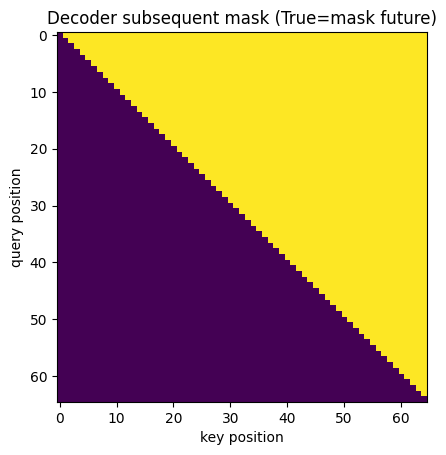

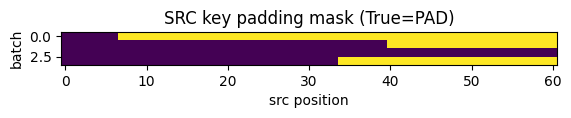

In [14]:
from torch.utils.data import DataLoader

train_loader_tok = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda b: collate_fn_space(b, src_stoi, tgt_stoi, max_src_len=128, max_tgt_len=128)
)

batch = next(iter(train_loader_tok))

for k, v in batch.items():
    if torch.is_tensor(v):
        print(k, v.shape, v.dtype)
    else:
        print(k, type(v), v)

print("\n示例 src ids[0]:", batch["src"][0][:30].tolist())
print("示例 tgt_in ids[0]:", batch["tgt_in"][0][:30].tolist())
print("示例 tgt_out ids[0]:", batch["tgt_out"][0][:30].tolist())

# 可视化 masks（可选）
plt.figure()
plt.imshow(batch["tgt_sub_mask"].cpu().numpy())
plt.title("Decoder subsequent mask (True=mask future)")
plt.xlabel("key position")
plt.ylabel("query position")
plt.show()

plt.figure()
plt.imshow(batch["src_key_padding_mask"].cpu().numpy())
plt.title("SRC key padding mask (True=PAD)")
plt.xlabel("src position")
plt.ylabel("batch")
plt.show()


# Step 7.1：位置编码 Positional Encoding（sin/cos）

In [25]:
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 2048, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

        pe = torch.zeros(max_len, d_model)  # [L, D]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [L,1]
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶数维
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇数维
        pe = pe.unsqueeze(0)  # [1, L, D]
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x: [B, L, D]
        L = x.size(1)
        x = x + self.pe[:, :L, :]
        return self.dropout(x)


# 位置编码热力图（Pos × Dim）

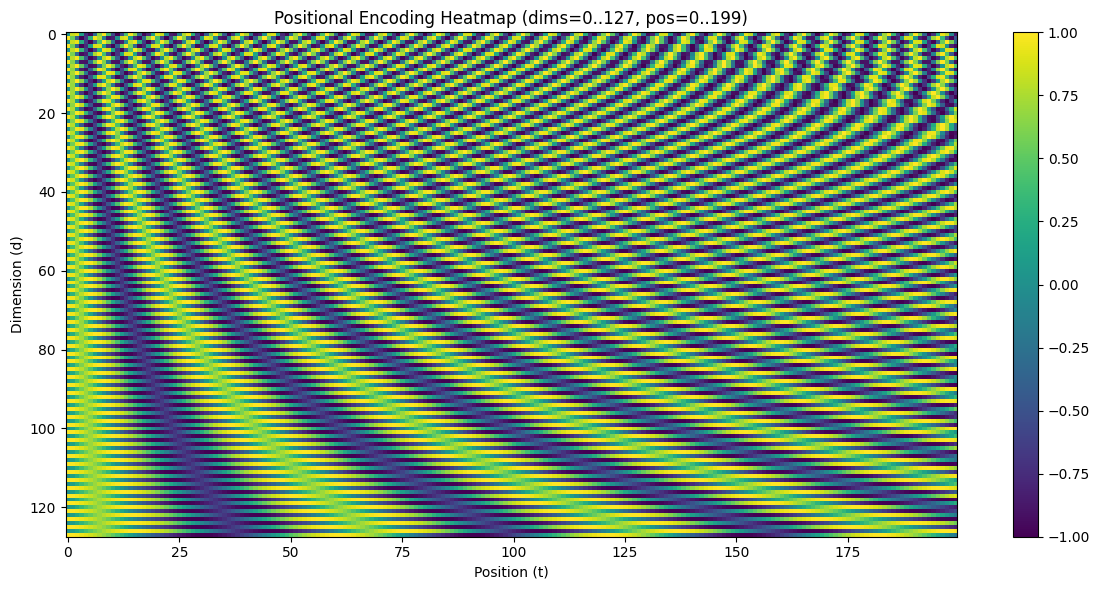

In [26]:
def visualize_pe_heatmap(pe_module: PositionalEncoding, L=200, D_show=128):
    """
    L: 展示前 L 个位置
    D_show: 展示前 D_show 个维度（太大图会很挤）
    """
    pe = pe_module.pe[0, :L, :D_show].detach().cpu().numpy()  # [L, D_show]
    pe = pe.T  # [D_show, L]  维度为行，位置为列

    plt.figure(figsize=(12, 6))
    plt.imshow(pe, aspect="auto")
    plt.title(f"Positional Encoding Heatmap (dims=0..{D_show-1}, pos=0..{L-1})")
    plt.xlabel("Position (t)")
    plt.ylabel("Dimension (d)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# 示例
pe = PositionalEncoding(d_model=512, max_len=2048, dropout=0.0)
visualize_pe_heatmap(pe, L=200, D_show=128)

# 选定维度的折线图（最直观）

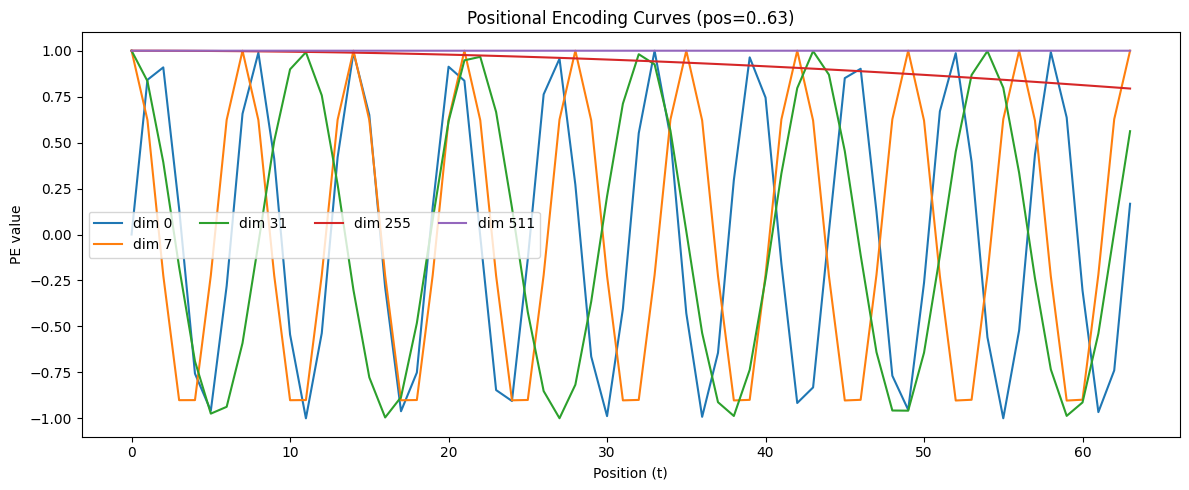

In [28]:
def visualize_pe_curves(pe_module: PositionalEncoding, dims=(0,1,2,3,10,11,100,101), L=200):
    """
    dims: 要画的维度列表
    L: 展示前 L 个位置
    """
    pe = pe_module.pe[0, :L, :].detach().cpu().numpy()  # [L, D]

    plt.figure(figsize=(12, 5))
    for d in dims:
        plt.plot(pe[:, d], label=f"dim {d}")
    plt.title(f"Positional Encoding Curves (pos=0..{L-1})")
    plt.xlabel("Position (t)")
    plt.ylabel("PE value")
    plt.legend(ncol=4)
    plt.tight_layout()
    plt.show()

# 示例
visualize_pe_curves(pe, dims= (0, 7, 31, 255, 511), L=64)


# 对比不同 d_model 的 PE（热力图）

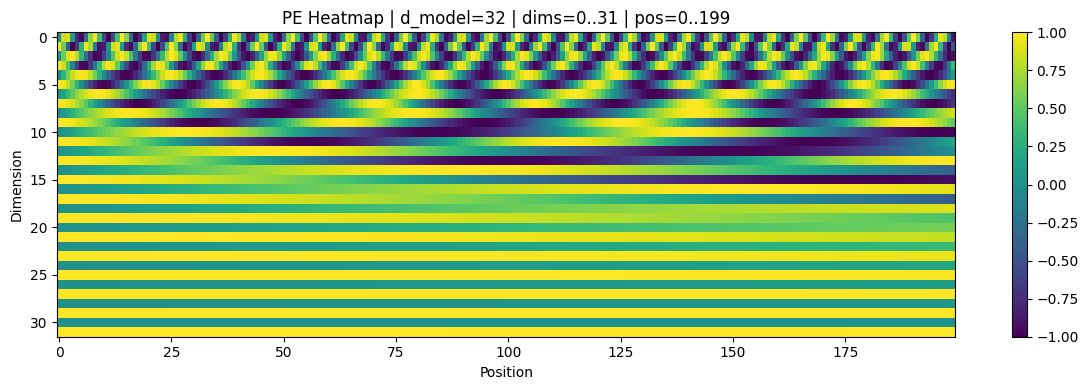

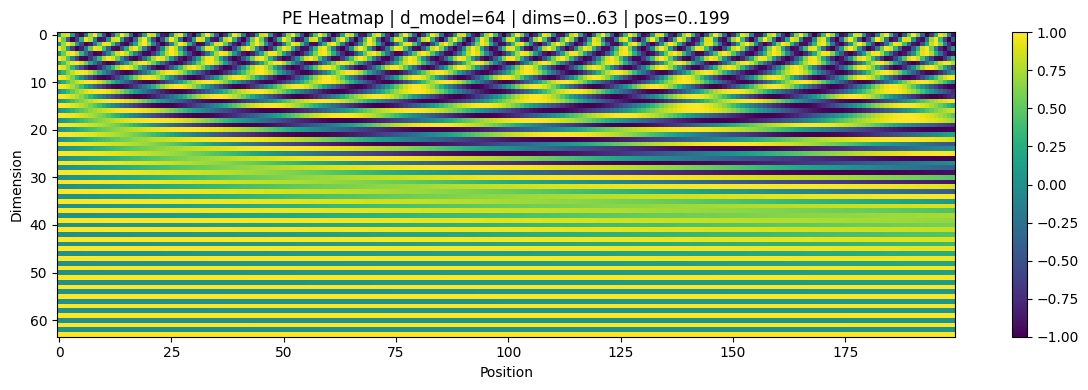

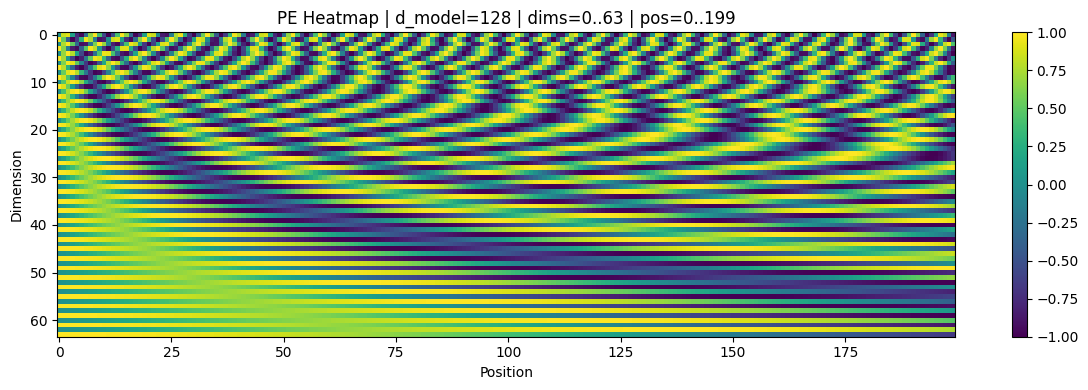

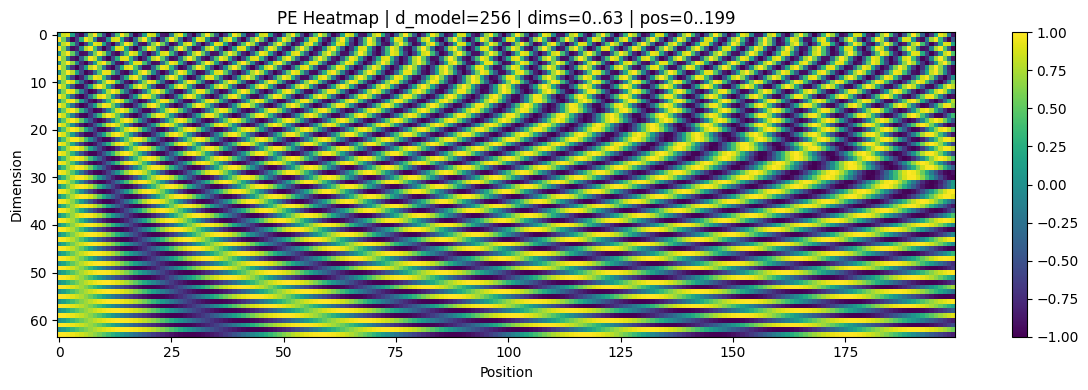

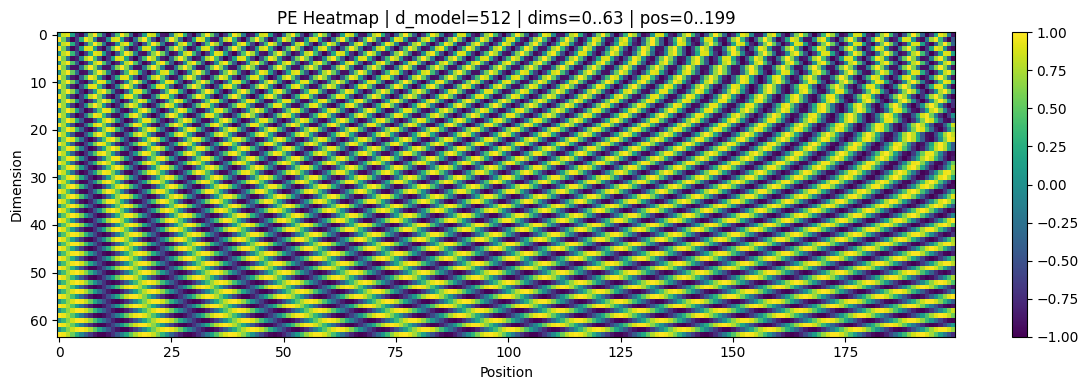

In [30]:
import torch
import matplotlib.pyplot as plt

def show_pe_heatmap_for_d_model(d_model_list=(32, 64, 128, 256, 512), L=200, D_show=64):
    for d_model in d_model_list:
        pe = PositionalEncoding(d_model=d_model, max_len=2048, dropout=0.0)  # dropout=0 方便观察本体
        D = min(D_show, d_model)
        mat = pe.pe[0, :L, :D].detach().cpu().numpy().T  # [D, L]

        plt.figure(figsize=(12, 4))
        plt.imshow(mat, aspect="auto")
        plt.title(f"PE Heatmap | d_model={d_model} | dims=0..{D-1} | pos=0..{L-1}")
        plt.xlabel("Position")
        plt.ylabel("Dimension")
        plt.colorbar()
        plt.tight_layout()
        plt.show()

show_pe_heatmap_for_d_model(d_model_list=(32, 64, 128, 256, 512), L=200, D_show=64)


# 对比不同 dropout 的影响（训练模式 vs 推理模式）

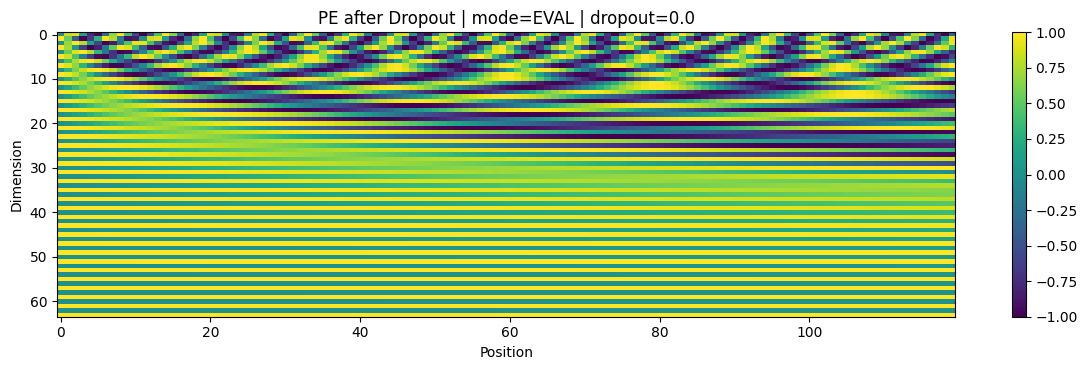

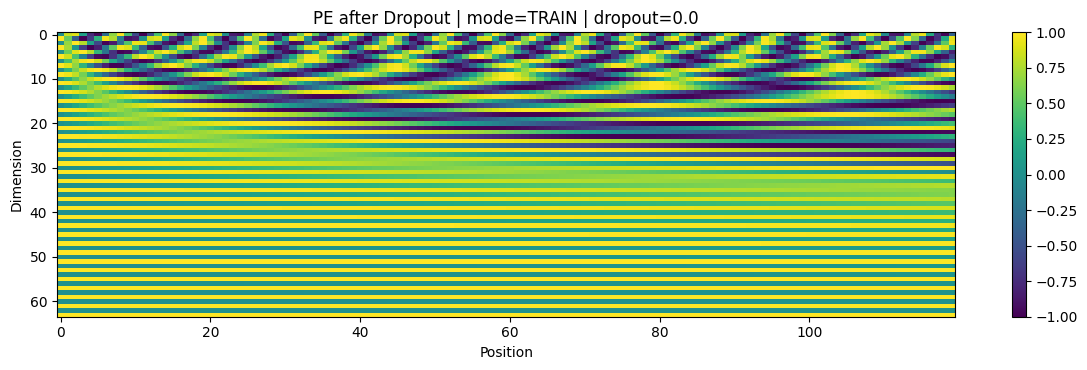

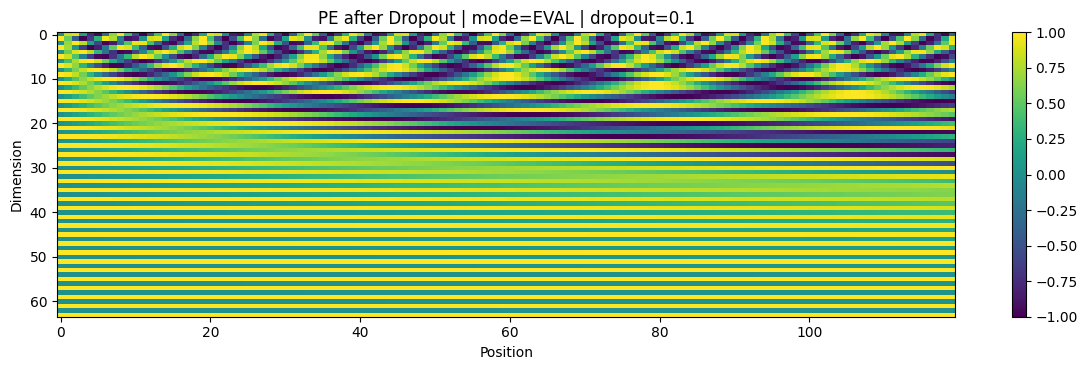

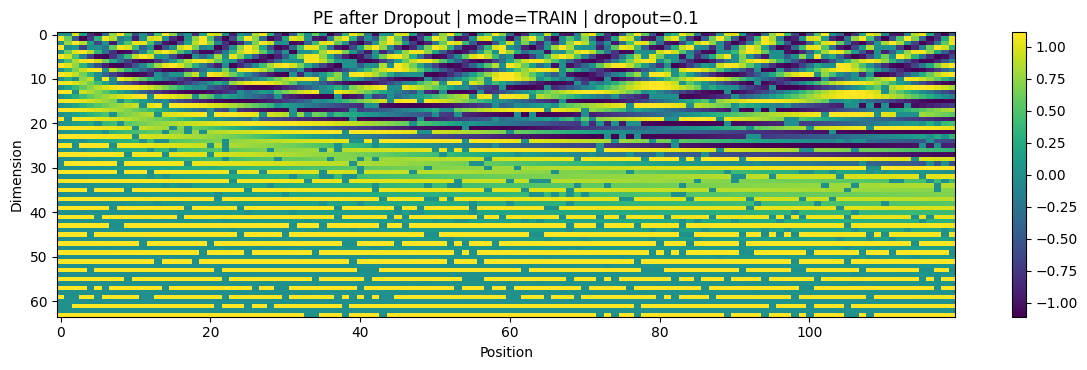

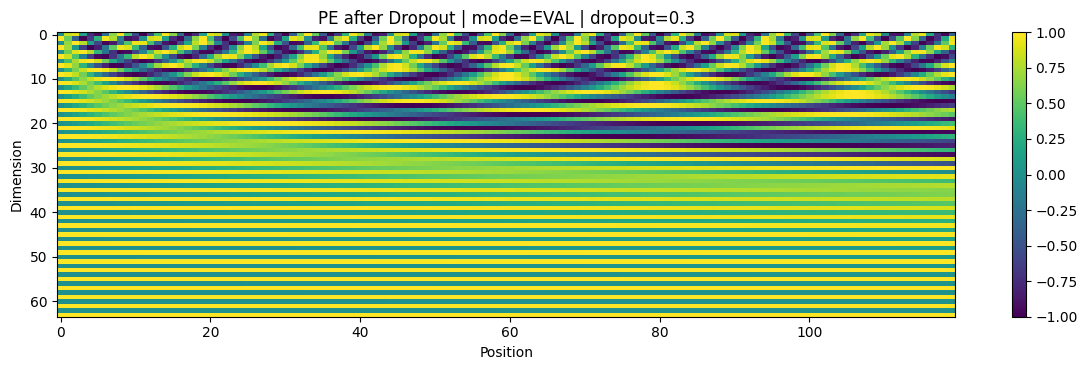

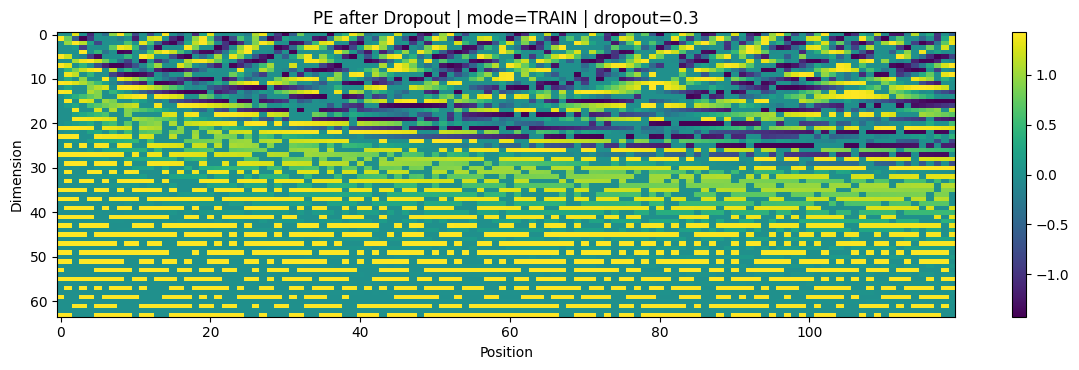

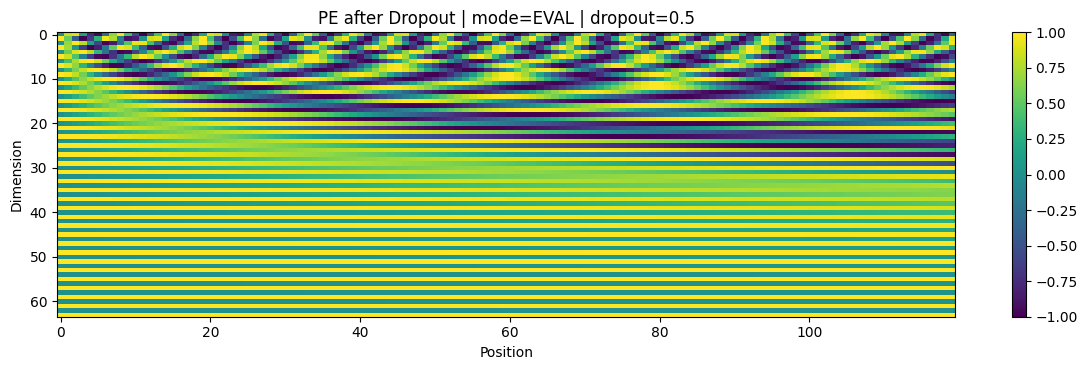

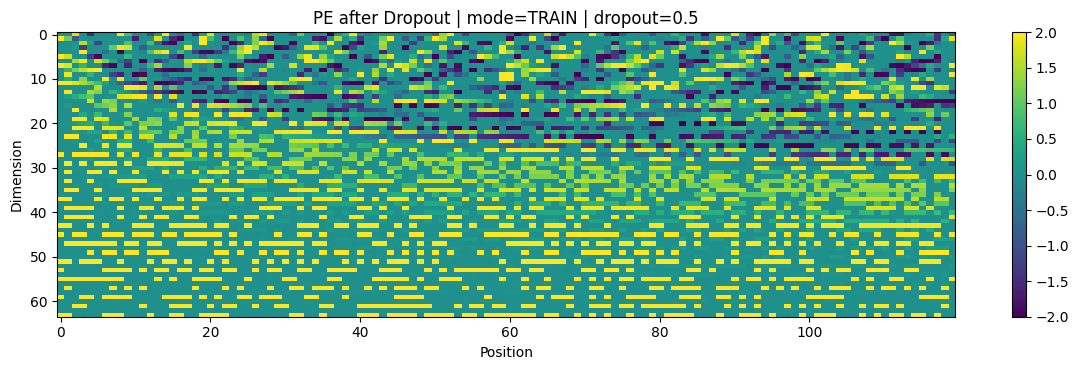

In [32]:
def show_dropout_comparison(d_model=64, L=120, dropouts=(0.0, 0.1, 0.3, 0.5), seed=0):
    x = torch.zeros(1, L, d_model)

    for p in dropouts:
        torch.manual_seed(seed)
        pe = PositionalEncoding(d_model=d_model, max_len=2048, dropout=p)

        # eval：dropout 关闭
        pe.eval()
        y_eval = pe(x).detach().cpu().numpy()[0].T  # [D, L]

        plt.figure(figsize=(12, 3.8))
        plt.imshow(y_eval, aspect="auto")
        plt.title(f"PE after Dropout | mode=EVAL | dropout={p}")
        plt.xlabel("Position")
        plt.ylabel("Dimension")
        plt.colorbar()
        plt.tight_layout()
        plt.show()

        # train：dropout 开启（注意：同 seed 下每次运行仍可能不同，但更可控）
        torch.manual_seed(seed)
        pe.train()
        y_train = pe(x).detach().cpu().numpy()[0].T  # [D, L]

        plt.figure(figsize=(12, 3.8))
        plt.imshow(y_train, aspect="auto")
        plt.title(f"PE after Dropout | mode=TRAIN | dropout={p}")
        plt.xlabel("Position")
        plt.ylabel("Dimension")
        plt.colorbar()
        plt.tight_layout()
        plt.show()

show_dropout_comparison(d_model=64, L=120, dropouts=(0.0, 0.1, 0.3, 0.5), seed=1)


# Step 7.2：多头注意力 Multi-Head Attention（支持 mask）

In [34]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.Wo = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def _split_heads(self, x):
        B, L, D = x.shape
        x = x.view(B, L, self.n_heads, self.d_head).transpose(1, 2)
        return x  # [B,H,L,Dh]

    def _merge_heads(self, x):
        B, H, L, Dh = x.shape
        return x.transpose(1, 2).contiguous().view(B, L, H * Dh)  # [B,L,D]

    def forward(self, q, k, v, attn_mask=None, key_padding_mask=None, return_attn=False):
        Q = self._split_heads(self.Wq(q))
        K = self._split_heads(self.Wk(k))
        V = self._split_heads(self.Wv(v))

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_head)  # [B,H,Lq,Lk]

        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask.unsqueeze(0).unsqueeze(0), float("-inf"))

        if key_padding_mask is not None:
            scores = scores.masked_fill(key_padding_mask.unsqueeze(1).unsqueeze(1), float("-inf"))

        attn = torch.softmax(scores, dim=-1)  # [B,H,Lq,Lk]
        attn = self.dropout(attn)

        out = torch.matmul(attn, V)          # [B,H,Lq,Dh]
        out = self._merge_heads(out)         # [B,Lq,D]
        out = self.Wo(out)

        if return_attn:
            return out, attn
        return out


# 一个通用的注意力热力图绘制器（支持 token 标签）

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def plot_attention_heatmap(attn, q_tokens=None, k_tokens=None, title="", max_q=40, max_k=40):
    """
    attn: [Lq, Lk] 的 numpy 或 torch
    q_tokens: List[str] 长度 Lq（可选）
    k_tokens: List[str] 长度 Lk（可选）
    """
    if torch.is_tensor(attn):
        attn = attn.detach().cpu().numpy()

    Lq, Lk = attn.shape
    Lq_show = min(Lq, max_q)
    Lk_show = min(Lk, max_k)
    attn_show = attn[:Lq_show, :Lk_show]

    plt.figure(figsize=(12, 6))
    plt.imshow(attn_show, aspect="auto")
    plt.title(title)
    plt.xlabel("Key positions")
    plt.ylabel("Query positions")
    plt.colorbar()
    
    if k_tokens is not None:
        plt.xticks(range(Lk_show), k_tokens[:Lk_show], rotation=90)
    if q_tokens is not None:
        plt.yticks(range(Lq_show), q_tokens[:Lq_show])
        
    plt.tight_layout()
    plt.show()


# 先用“随机输入”跑一次 MHA 并画 attention（最容易验证）

out shape: torch.Size([1, 20, 64]) attn shape: torch.Size([1, 4, 20, 20])


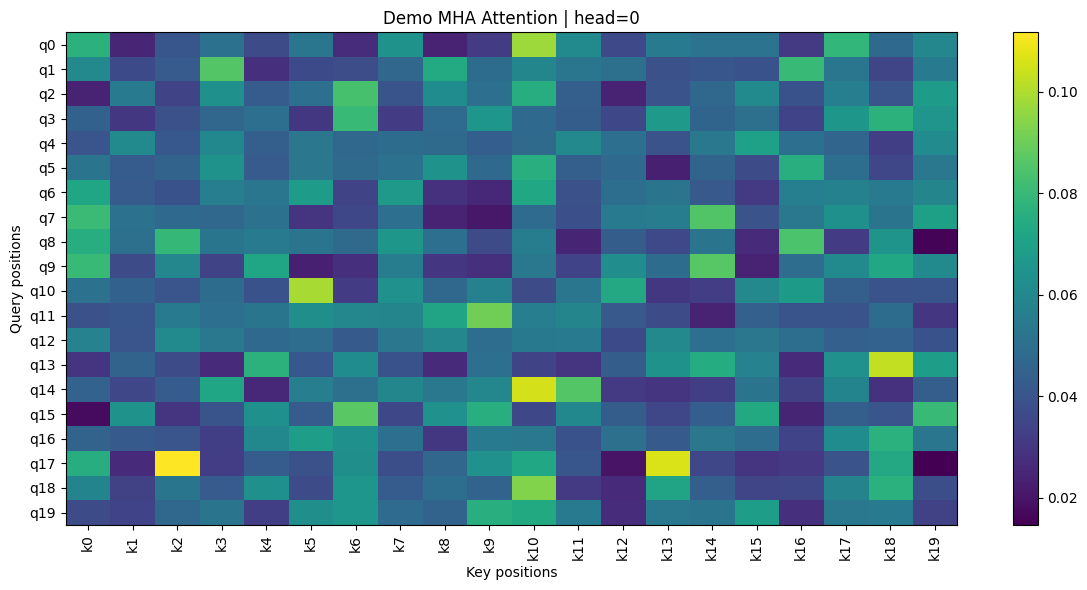

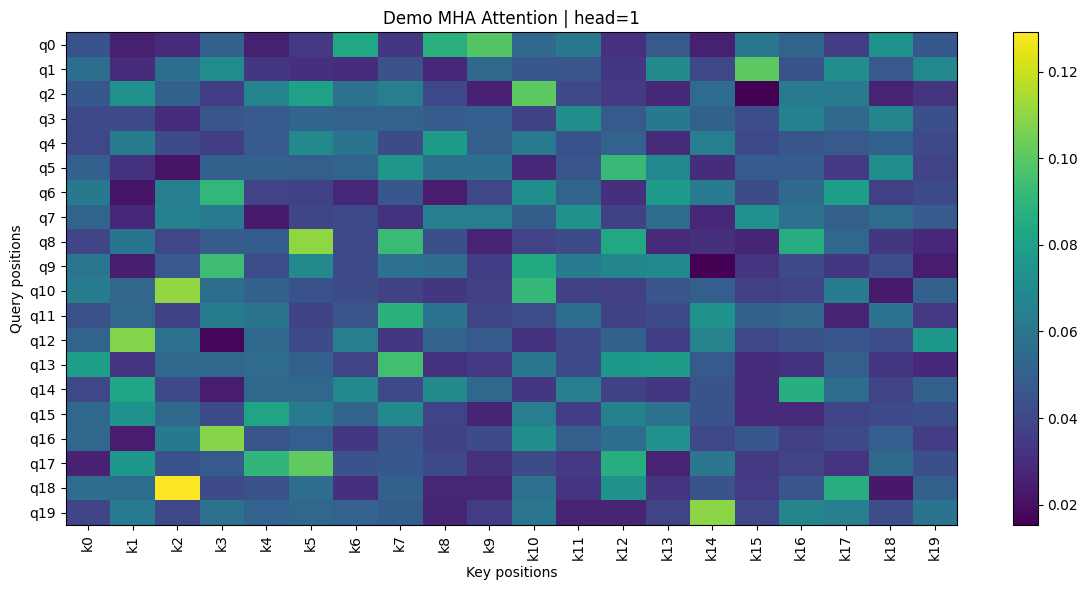

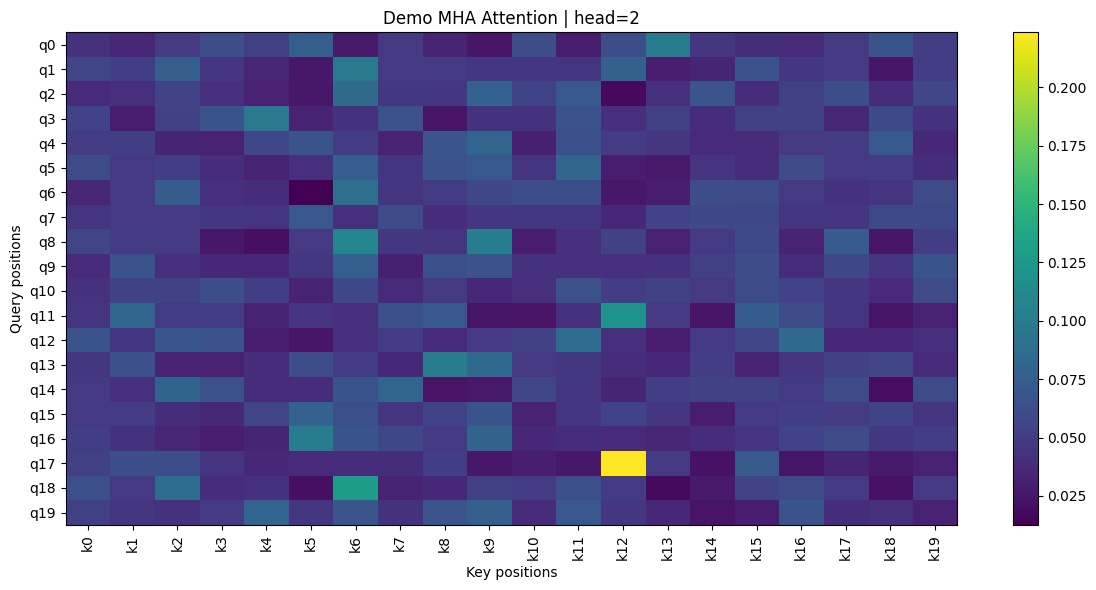

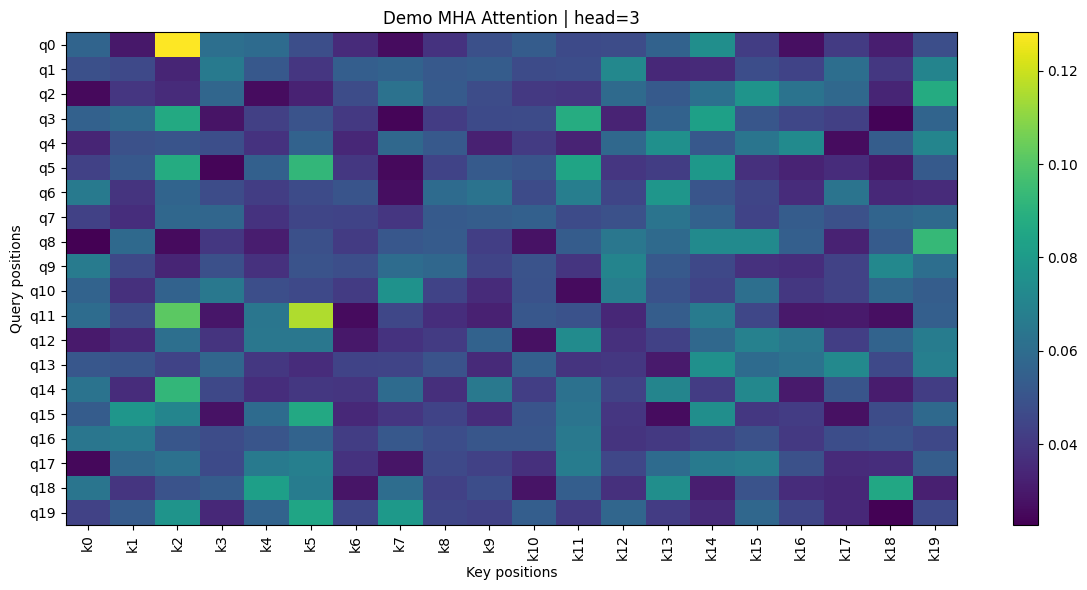

In [35]:
def demo_mha_visualization(d_model=64, n_heads=4, Lq=20, Lk=20, dropout=0.0, seed=0):
    torch.manual_seed(seed)
    mha = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
    mha.eval()

    q = torch.randn(1, Lq, d_model)
    k = torch.randn(1, Lk, d_model)
    v = torch.randn(1, Lk, d_model)

    out, attn = mha(q, k, v, return_attn=True)  # attn: [B,H,Lq,Lk]
    print("out shape:", out.shape, "attn shape:", attn.shape)

    # 画每个 head 的注意力
    for h in range(n_heads):
        plot_attention_heatmap(
            attn[0, h],
            q_tokens=[f"q{t}" for t in range(Lq)],
            k_tokens=[f"k{t}" for t in range(Lk)],
            title=f"Demo MHA Attention | head={h}"
        )

demo_mha_visualization(d_model=64, n_heads=4, Lq=20, Lk=20, dropout=0.0, seed=1)


# 可视化 mask 的效果（很关键！）

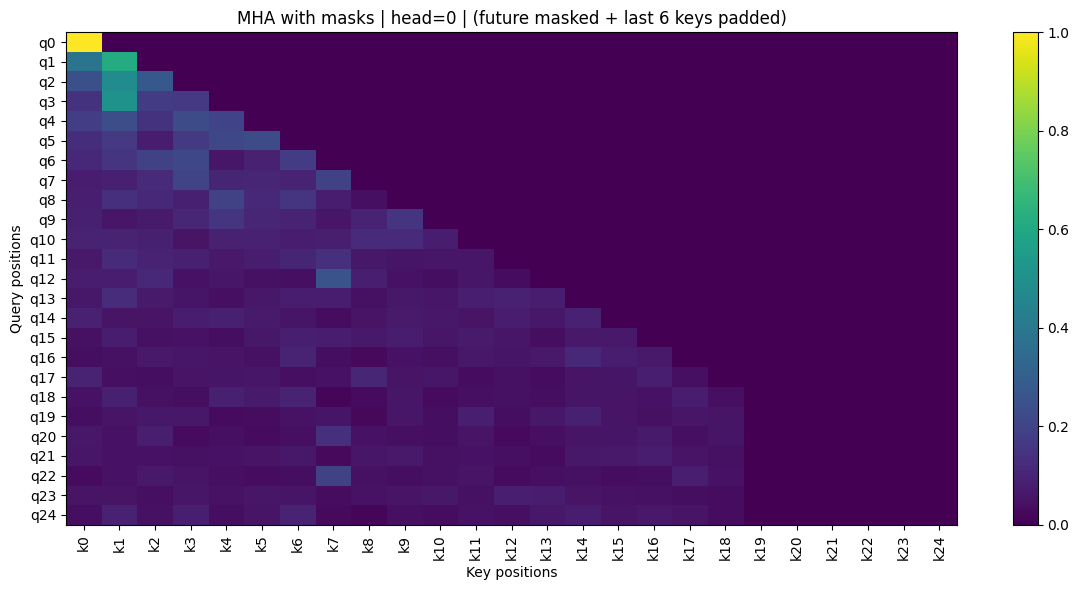

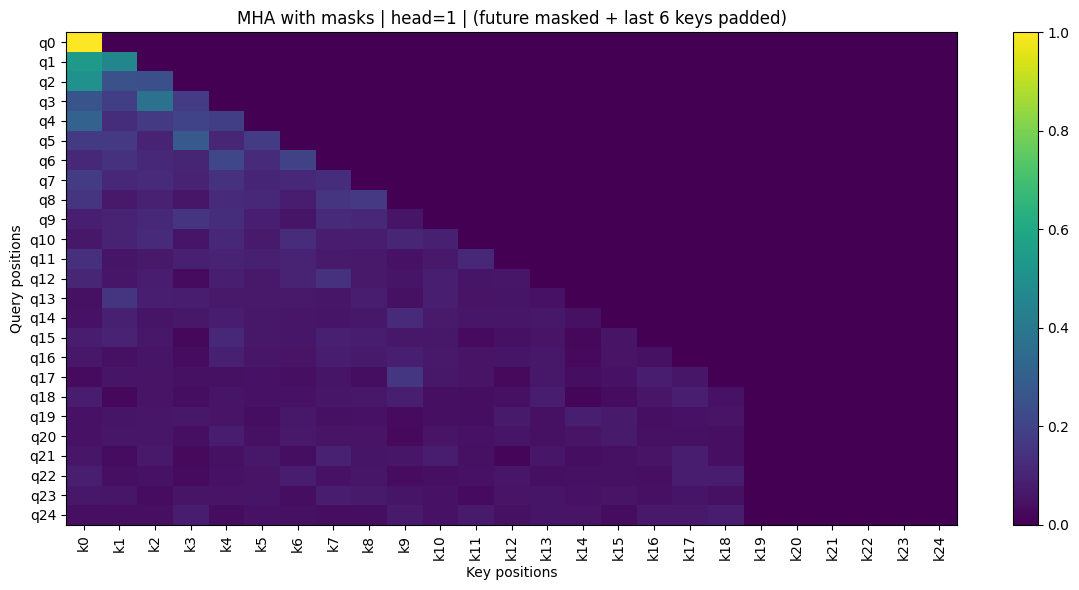

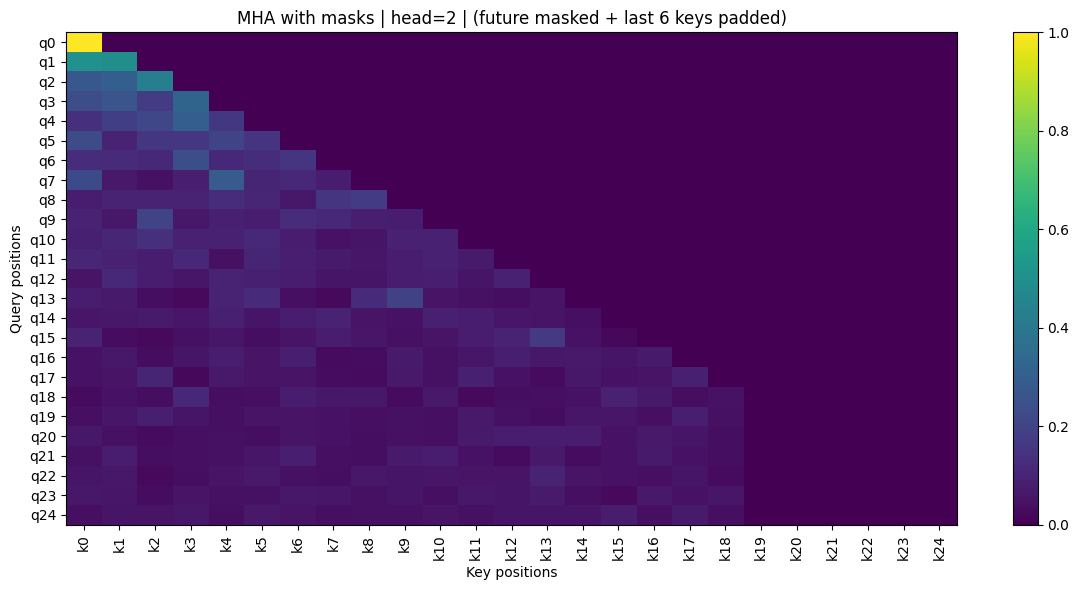

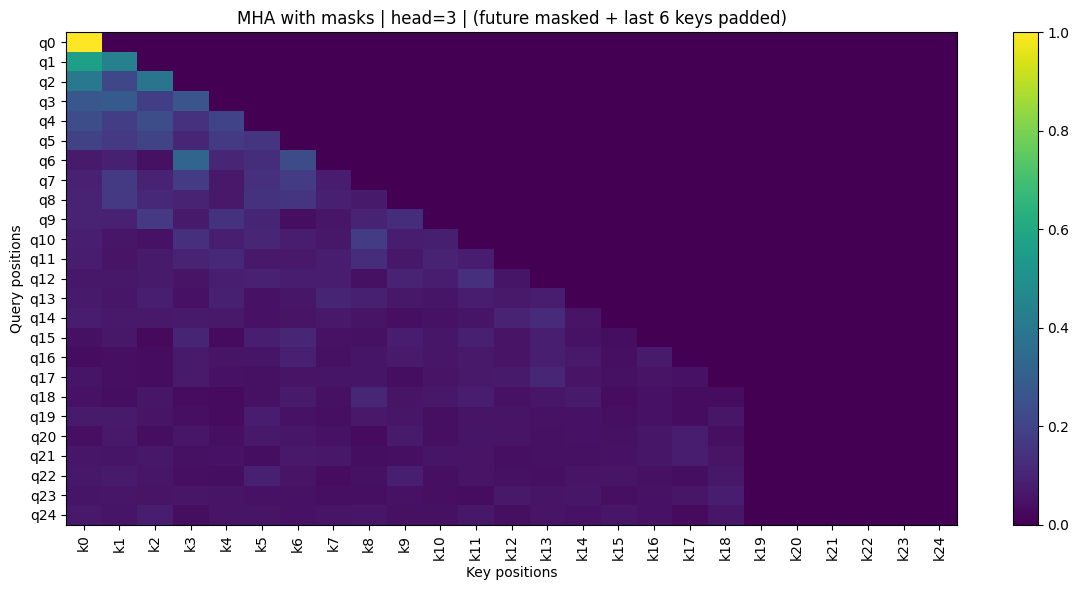

In [36]:
def demo_mha_mask_visualization(d_model=64, n_heads=4, L=25, pad_tail=6, dropout=0.0, seed=0):
    torch.manual_seed(seed)
    mha = MultiHeadAttention(d_model=d_model, n_heads=n_heads, dropout=dropout)
    mha.eval()

    q = torch.randn(1, L, d_model)
    k = torch.randn(1, L, d_model)
    v = torch.randn(1, L, d_model)

    # subsequent mask: [L, L] True=mask future
    attn_mask = torch.triu(torch.ones(L, L, dtype=torch.bool), diagonal=1)

    # key padding mask: [B, L] True=PAD
    key_padding_mask = torch.zeros(1, L, dtype=torch.bool)
    key_padding_mask[0, -pad_tail:] = True  # 后面 pad_tail 个位置当作 PAD

    out, attn = mha(q, k, v, attn_mask=attn_mask, key_padding_mask=key_padding_mask, return_attn=True)

    for h in range(n_heads):
        plot_attention_heatmap(
            attn[0, h],
            q_tokens=[f"q{t}" for t in range(L)],
            k_tokens=[f"k{t}" for t in range(L)],
            title=f"MHA with masks | head={h} | (future masked + last {pad_tail} keys padded)"
        )

demo_mha_mask_visualization(d_model=64, n_heads=4, L=25, pad_tail=6, dropout=0.0, seed=2)


# 把注意力可视化“接入你的翻译 batch”（显示真实 token 标签）

# Step 7.3：前馈网络 FFN + LayerNorm + 残差

In [38]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.net(x))

class AddNorm(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer_out):
        return self.norm(x + self.dropout(sublayer_out))


# Step 7.4：EncoderLayer / DecoderLayer

In [39]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.addnorm1 = AddNorm(d_model, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.addnorm2 = AddNorm(d_model, dropout)

    def forward(self, x, src_key_padding_mask=None):
        # Self-attn
        sa = self.self_attn(x, x, x, attn_mask=None, key_padding_mask=src_key_padding_mask)
        x = self.addnorm1(x, sa)
        # FFN
        ff = self.ffn(x)
        x = self.addnorm2(x, ff)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.addnorm1 = AddNorm(d_model, dropout)

        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.addnorm2 = AddNorm(d_model, dropout)

        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.addnorm3 = AddNorm(d_model, dropout)

        self.last_cross_attn = None  # ✅存起来用于可视化

    def forward(self, x, memory, tgt_sub_mask=None, tgt_key_padding_mask=None, src_key_padding_mask=None):
        sa = self.self_attn(x, x, x, attn_mask=tgt_sub_mask, key_padding_mask=tgt_key_padding_mask)
        x = self.addnorm1(x, sa)

        # ✅拿到 cross-attn 的权重
        ca_out, ca_attn = self.cross_attn(
            x, memory, memory,
            attn_mask=None,
            key_padding_mask=src_key_padding_mask,
            return_attn=True
        )
        self.last_cross_attn = ca_attn  # [B,H,T,S]
        x = self.addnorm2(x, ca_out)

        ff = self.ffn(x)
        x = self.addnorm3(x, ff)
        return x



# Step 7.5：完整 Transformer（Embedding + PE + 堆叠 + 输出 logits）

In [46]:
class TransformerNMT(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, n_heads=8, d_ff=2048,
                 num_layers=6, dropout=0.1, max_len=2048):
        super().__init__()
        self.d_model = d_model

        self.src_emb = nn.Embedding(src_vocab_size, d_model, padding_idx=PAD_ID)
        self.tgt_emb = nn.Embedding(tgt_vocab_size, d_model, padding_idx=PAD_ID)

        self.pos = PositionalEncoding(d_model, max_len=max_len, dropout=dropout)

        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout) for _ in range(num_layers)
        ])

        self.out = nn.Linear(d_model, tgt_vocab_size)

    def encode(self, src, src_key_padding_mask=None):
        x = self.src_emb(src) * math.sqrt(self.d_model)  # [B,S,D]
        x = self.pos(x)
        for layer in self.enc_layers:
            x = layer(x, src_key_padding_mask=src_key_padding_mask)
        return x

    def decode(self, tgt_in, memory, tgt_sub_mask=None, tgt_key_padding_mask=None, src_key_padding_mask=None):
        x = self.tgt_emb(tgt_in) * math.sqrt(self.d_model)  # [B,T,D]
        x = self.pos(x)
        for layer in self.dec_layers:
            x = layer(
                x, memory,
                tgt_sub_mask=tgt_sub_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                src_key_padding_mask=src_key_padding_mask
            )
        return x

    def forward(self, src, tgt_in, src_key_padding_mask=None, tgt_key_padding_mask=None, tgt_sub_mask=None):
        memory = self.encode(src, src_key_padding_mask=src_key_padding_mask)
        dec = self.decode(
            tgt_in, memory,
            tgt_sub_mask=tgt_sub_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            src_key_padding_mask=src_key_padding_mask
        )
        logits = self.out(dec)  # [B,T,V]
        return logits


# Step 7.6：用你 Step 6 的 batch 做一次前向（确认维度）

In [54]:
# 用 cfg 里的 Transformer 超参数（你前面 CFG 若不同，可直接填数字）
model = TransformerNMT(
    src_vocab_size=len(src_itos),
    tgt_vocab_size=len(tgt_itos),
    d_model=512, n_heads=8, d_ff=2048,
    num_layers=6,   # ✅先用2层快速验证能跑，之后再改回6
    dropout=0.1,
    max_len=512
).to(device)

batch = next(iter(train_loader_tok))

src = batch["src"].to(device)
tgt_in = batch["tgt_in"].to(device)
src_kpm = batch["src_key_padding_mask"].to(device)
tgt_kpm = batch["tgt_key_padding_mask"].to(device)
tgt_sub = batch["tgt_sub_mask"].to(device)

with torch.no_grad():
    logits = model(src, tgt_in, src_key_padding_mask=src_kpm, tgt_key_padding_mask=tgt_kpm, tgt_sub_mask=tgt_sub)

print("logits:", logits.shape)  # [B, T, V]


logits: torch.Size([4, 72, 60000])


# 可视化：把一条 batch 的 token 还原成文字（最直观）

In [55]:
def ids_to_tokens(ids, itos):
    out = []
    for i in ids:
        if i < 0 or i >= len(itos):
            out.append("<bad_id>")
        else:
            out.append(itos[i])
    return out

def show_example_from_batch(batch, idx=0, max_show=60):
    src_ids = batch["src"][idx].tolist()
    tgt_in_ids = batch["tgt_in"][idx].tolist()
    tgt_out_ids = batch["tgt_out"][idx].tolist()

    src_toks = ids_to_tokens(src_ids, src_itos)[:max_show]
    tgt_in_toks = ids_to_tokens(tgt_in_ids, tgt_itos)[:max_show]
    tgt_out_toks = ids_to_tokens(tgt_out_ids, tgt_itos)[:max_show]

    print("SRC ids  :", src_ids[:max_show])
    print("SRC toks :", " ".join(src_toks))
    print()
    print("TGT_IN ids :", tgt_in_ids[:max_show])
    print("TGT_IN toks:", " ".join(tgt_in_toks))
    print()
    print("TGT_OUT ids :", tgt_out_ids[:max_show])
    print("TGT_OUT toks:", " ".join(tgt_out_toks))

batch = next(iter(train_loader_tok))
show_example_from_batch(batch, idx=0, max_show=50)


SRC ids  : [2, 19483, 14357, 1692, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SRC toks : <bos> 西贡 区议会 秘书 <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

TGT_IN ids : [2, 2880, 72, 113, 17, 15632, 18050, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0]
TGT_IN toks: <bos> district Council Secretary ( Sai Kung ) <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

TGT_OUT ids : [2880, 72, 113, 17, 15632, 18050, 16, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]
TGT_OUT toks: district Council Secretary ( Sai Kung ) <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


# 可视化：Padding mask + Subsequent mask（你会秒懂 mask 的意义）

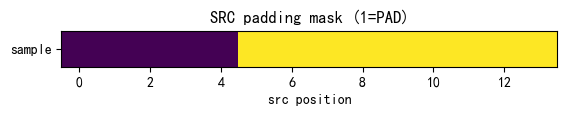

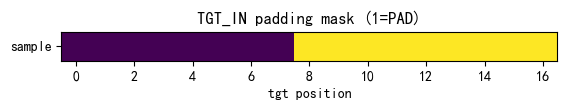

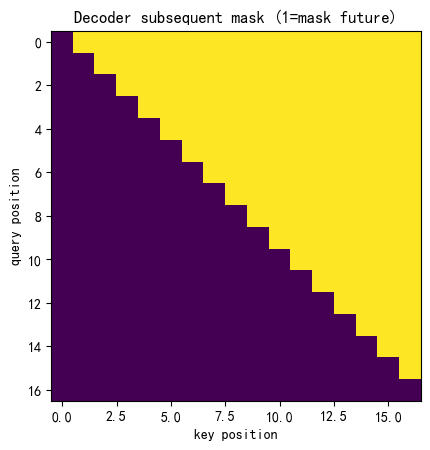

In [56]:
import matplotlib.pyplot as plt
import numpy as np

def show_masks(batch, idx=0):
    src_kpm = batch["src_key_padding_mask"][idx].cpu().numpy().astype(int)  # [S]
    tgt_kpm = batch["tgt_key_padding_mask"][idx].cpu().numpy().astype(int)  # [T]
    sub = batch["tgt_sub_mask"].cpu().numpy().astype(int)                   # [T,T]

    plt.figure()
    plt.imshow(src_kpm[None, :])
    plt.title("SRC padding mask (1=PAD)")
    plt.yticks([0], ["sample"])
    plt.xlabel("src position")
    plt.show()

    plt.figure()
    plt.imshow(tgt_kpm[None, :])
    plt.title("TGT_IN padding mask (1=PAD)")
    plt.yticks([0], ["sample"])
    plt.xlabel("tgt position")
    plt.show()

    plt.figure()
    plt.imshow(sub)
    plt.title("Decoder subsequent mask (1=mask future)")
    plt.xlabel("key position")
    plt.ylabel("query position")
    plt.show()

show_masks(batch, idx=0)


# 可视化：画 cross-attention 对齐热力图（tgt 行，src 列）

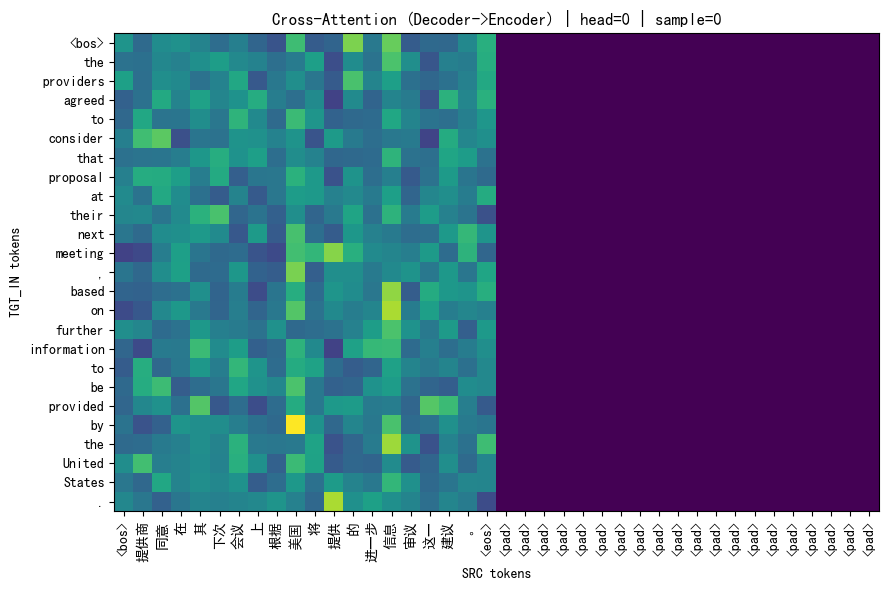

In [57]:
# ========== 中文显示（尽量兼容 Windows 常见字体） ==========
plt.rcParams["font.family"] = ["SimHei", "Microsoft YaHei", "SimSun"]
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示问题
def plot_cross_attention(model, batch, sample_idx=0, head_idx=0, max_src=40, max_tgt=25):
    model.eval()
    with torch.no_grad():
        src = batch["src"].to(device)
        tgt_in = batch["tgt_in"].to(device)
        src_kpm = batch["src_key_padding_mask"].to(device)
        tgt_kpm = batch["tgt_key_padding_mask"].to(device)
        tgt_sub = batch["tgt_sub_mask"].to(device)

        _ = model(src, tgt_in, src_key_padding_mask=src_kpm, tgt_key_padding_mask=tgt_kpm, tgt_sub_mask=tgt_sub)

    # 拿最后一层 decoder 的 cross-attn
    last_layer = model.dec_layers[-1]
    attn = last_layer.last_cross_attn  # [B,H,T,S]
    attn = attn[sample_idx, head_idx].detach().cpu().numpy()  # [T,S]

    # 取 token 文本
    src_ids = batch["src"][sample_idx].tolist()
    tgt_ids = batch["tgt_in"][sample_idx].tolist()

    src_toks = ids_to_tokens(src_ids, src_itos)[:max_src]
    tgt_toks = ids_to_tokens(tgt_ids, tgt_itos)[:max_tgt]

    attn = attn[:len(tgt_toks), :len(src_toks)]

    plt.figure(figsize=(12, 6))
    plt.imshow(attn)
    plt.title(f"Cross-Attention (Decoder->Encoder) | head={head_idx} | sample={sample_idx}")
    plt.xlabel("SRC tokens")
    plt.ylabel("TGT_IN tokens")
    plt.xticks(range(len(src_toks)), src_toks, rotation=90)
    plt.yticks(range(len(tgt_toks)), tgt_toks)
    plt.tight_layout()
    plt.show()

# 先确保 model 已经重新实例化或重新运行了相关 cell（因为我们改了类定义）
batch = next(iter(train_loader_tok))
plot_cross_attention(model, batch, sample_idx=0, head_idx=0)


# 深度解析
# 0) 小样本抽取（固定随机种子，保证可复现）

In [62]:
import random
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 你已有：train_pairs（list of (src,tgt)）
# 这里抽一个小样本
seed = 42
random.seed(seed)

N_SAMPLE = 64  # 小样本数量（你可改成 128/256）
small_pairs = random.sample(train_pairs, N_SAMPLE)

class TranslationPairsDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
    def __len__(self):
        return len(self.pairs)
    def __getitem__(self, idx):
        src, tgt = self.pairs[idx]
        return {"src_text": src, "tgt_text": tgt}

small_ds = TranslationPairsDataset(small_pairs)

# 你已有 collate_fn_space(batch, src_stoi, tgt_stoi, max_src_len, max_tgt_len)
small_loader = DataLoader(
    small_ds,
    batch_size=8,
    shuffle=True,
    collate_fn=lambda b: collate_fn_space(b, src_stoi, tgt_stoi, max_src_len=64, max_tgt_len=64)
)

batch = next(iter(small_loader))
print("src:", batch["src"].shape, "tgt_in:", batch["tgt_in"].shape, "tgt_out:", batch["tgt_out"].shape)

def show_raw_samples(pairs, n=5, max_chars=140):
    print(f"=== Raw samples (n={n}) ===")
    for i, (src, tgt) in enumerate(pairs[:n]):
        src_show = src[:max_chars] + ("..." if len(src) > max_chars else "")
        tgt_show = tgt[:max_chars] + ("..." if len(tgt) > max_chars else "")
        print(f"[{i}] SRC: {src_show}")
        print(f"    TGT: {tgt_show}")
        print("-" * 80)

show_raw_samples(small_pairs, n=5)



src: torch.Size([8, 29]) tgt_in: torch.Size([8, 42]) tgt_out: torch.Size([8, 42])
=== Raw samples (n=5) ===
[0] SRC: 马耳他 的 初次 、 第二次 和 第三次 合并 定期 报告 （ CEDAW / C / MLT / 1 - 3 ）
    TGT: combined initial , second and third periodic report of Malta ( CEDAW / C / MLT / 1 @-@ 3 )
--------------------------------------------------------------------------------
[1] SRC: 他们 在 监狱 里 被 关 了 18 天 ， 一直 没有 受到 审问 ， 直到 6 月 10 日 被 告知 获释 。
    TGT: they were kept in jail for 18 days without interrogation until 10 June , when they were told they would be set free .
--------------------------------------------------------------------------------
[2] SRC: 细则 109.3
    TGT: rule 109.3
--------------------------------------------------------------------------------
[3] SRC: 人生 应该 树立 目标 ， 否则 你 的 精力 会 白白浪费
    TGT: have an aim in life , or your energies will all be wasted.R
--------------------------------------------------------------------------------
[4] SRC: 你 不要 喝 红牛 ， 虽然 红牛 口口声声 说 它 可以 帮助 你 提神 ， 但是 依 我 的 经

=== Batch sample idx=0 ===
SRC TOKENS: <bos> 安理会 成员 期望 所有 各方 充分 履行 他们 在 脱离 接触 协定 中所作 的 承诺 ， 毫无保留 地 同联 刚 特派团 合作 ， 推行 这些 计划 ， 并 至少 在 5 月 15 日 的 最后 期限 之前 为 外国 部队 按 第 1304 （ 2000 ） 号 决议 的 规定 从 刚果民主共和国 全部 撤出 拟定 切合实际 的 计划
SRC IDS   : [2, 576, 217, 2000, 91, 895, 418, 552, 84, 8, 3242, 1241, 503, 9731, 4, 399, 5, 17012, 97, 27758, 3735, 277, 118, 5, 2390, 62, 177, 5, 22, 1006, 8, 117, 19, 304, 38, 4, 384, 1521, 527, 28, 929, 476, 563, 21, 56724, 49, 463, 50, 90, 85, 4, 112, 126, 1454, 1199, 3881, 1669, 9399, 4, 177]

TGT_IN TOKENS: <bos> members of the Council expect all parties to live up fully to their commitments under the disengagement agreements , cooperate unreservedly with MONUC in taking those plans forward , and , not least , draw up realistic plans -- which are due by 15 May -- for the complete withdrawal of foreign troops from the Democratic Republic of the
TGT_IN IDS   : [2, 189, 6, 4, 72, 3218, 45, 256, 9, 1104, 90, 608, 9, 42, 1077, 75, 4, 16006, 849, 5, 1970, 28047, 19, 4417, 1

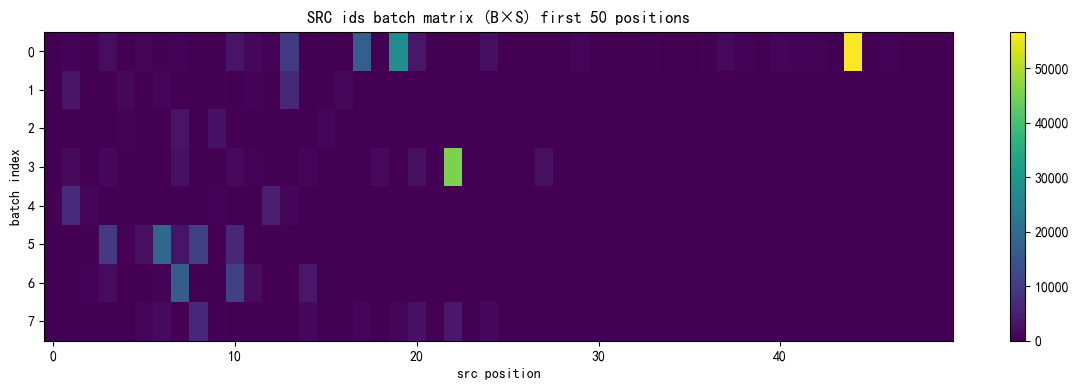

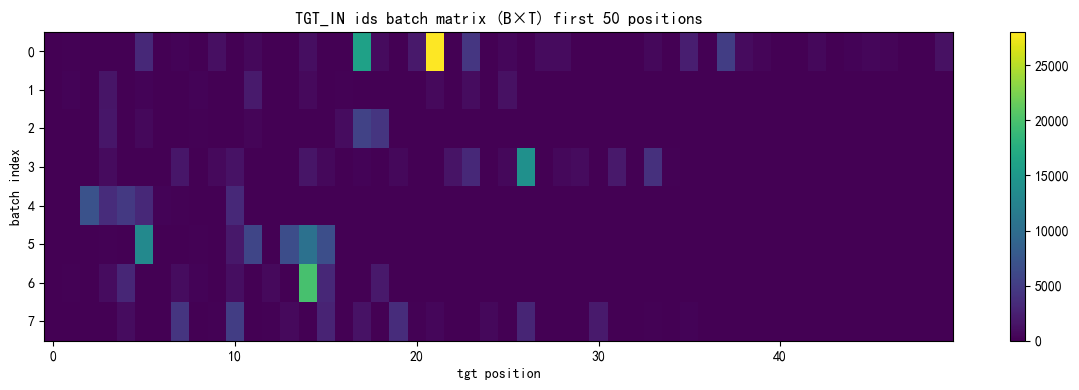



=== Batch sample idx=1 ===
SRC TOKENS: <bos> 每次 报告 提出 以后 ， 允许 委员会 成员 发言 进行 对话 、 提问 和 作出 评论 。 <eos> <pad>
SRC IDS   : [2, 2887, 42, 119, 1302, 5, 811, 18, 217, 328, 59, 614, 10, 6487, 7, 253, 1273, 6, 3, 0]

TGT_IN TOKENS: <bos> following the introduction of each of these reports , the floor will be open to members of the Committee for dialogue , questions and comments . <pad>
TGT_IN IDS   : [2, 235, 4, 1583, 6, 268, 6, 94, 278, 5, 4, 2033, 47, 22, 720, 9, 189, 6, 4, 49, 12, 756, 5, 923, 8, 1247, 7, 0]

TGT_OUT TOKENS: following the introduction of each of these reports , the floor will be open to members of the Committee for dialogue , questions and comments . <eos> <pad>
TGT_OUT IDS   : [235, 4, 1583, 6, 268, 6, 94, 278, 5, 4, 2033, 47, 22, 720, 9, 189, 6, 4, 49, 12, 756, 5, 923, 8, 1247, 7, 3, 0]


In [70]:
# 如果你前面已经定义了这些，就不用重复定义：
# tokenize_space, encode, ids_to_tokens, PAD_ID, BOS_ID, EOS_ID, UNK_ID, src_itos, tgt_itos

def show_batch_sample(batch, sample_idx=0, max_show=50):
    src_ids = batch["src"][sample_idx].tolist()
    tgt_in_ids = batch["tgt_in"][sample_idx].tolist()
    tgt_out_ids = batch["tgt_out"][sample_idx].tolist()

    src_toks = ids_to_tokens(src_ids, src_itos)
    tgt_in_toks = ids_to_tokens(tgt_in_ids, tgt_itos)
    tgt_out_toks = ids_to_tokens(tgt_out_ids, tgt_itos)

    # 截断显示（遇到 PAD 就停止更直观）
    def trim_at_pad(ids, toks):
        out_ids, out_toks = [], []
        for i, t in zip(ids, toks):
            out_ids.append(i)
            out_toks.append(t)
            if i == PAD_ID:
                break
        return out_ids, out_toks

    src_ids_s, src_toks_s = trim_at_pad(src_ids, src_toks)
    tgt_in_ids_s, tgt_in_toks_s = trim_at_pad(tgt_in_ids, tgt_in_toks)
    tgt_out_ids_s, tgt_out_toks_s = trim_at_pad(tgt_out_ids, tgt_out_toks)

    print(f"=== Batch sample idx={sample_idx} ===")
    print("SRC TOKENS:", " ".join(src_toks_s[:max_show]))
    print("SRC IDS   :", src_ids_s[:max_show])
    print()
    print("TGT_IN TOKENS:", " ".join(tgt_in_toks_s[:max_show]))
    print("TGT_IN IDS   :", tgt_in_ids_s[:max_show])
    print()
    print("TGT_OUT TOKENS:", " ".join(tgt_out_toks_s[:max_show]))
    print("TGT_OUT IDS   :", tgt_out_ids_s[:max_show])

def plot_batch_id_matrices(batch, max_len=50):
    src_mat = batch["src"][:, :max_len].cpu().numpy()
    tgt_mat = batch["tgt_in"][:, :max_len].cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.imshow(src_mat, aspect="auto")
    plt.title(f"SRC ids batch matrix (B×S) first {max_len} positions")
    plt.xlabel("src position")
    plt.ylabel("batch index")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.imshow(tgt_mat, aspect="auto")
    plt.title(f"TGT_IN ids batch matrix (B×T) first {max_len} positions")
    plt.xlabel("tgt position")
    plt.ylabel("batch index")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

# 重新取一个 batch（确保你能看到不一样的）
batch = next(iter(small_loader))

show_batch_sample(batch, sample_idx=0, max_show=60)
print("\n--- matrix view ---")
plot_batch_id_matrices(batch, max_len=50)

# 也可以再看一个样本
print("\n=============================\n")
show_batch_sample(batch, sample_idx=1, max_show=60)


# 定义一个“可解释版 MultiHeadAttention”：把 Q/K/V、scores、attn 都保存下来

In [71]:
import torch.nn as nn
import math

class MultiHeadAttentionExplain(nn.Module):
    def __init__(self, d_model: int, n_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.Wo = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)

        # ====== 用于可视化的缓存（每次 forward 会更新）======
        self.cache = {}

    def _split_heads(self, x):
        B, L, D = x.shape
        return x.view(B, L, self.n_heads, self.d_head).transpose(1, 2)  # [B,H,L,Dh]

    def _merge_heads(self, x):
        B, H, L, Dh = x.shape
        return x.transpose(1, 2).contiguous().view(B, L, H * Dh)

    def forward(self, q, k, v, attn_mask=None, key_padding_mask=None, return_attn=False):
        Q_lin = self.Wq(q)  # [B,L,D]
        K_lin = self.Wk(k)
        V_lin = self.Wv(v)

        Q = self._split_heads(Q_lin)  # [B,H,Lq,Dh]
        K = self._split_heads(K_lin)  # [B,H,Lk,Dh]
        V = self._split_heads(V_lin)  # [B,H,Lk,Dh]

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_head)  # [B,H,Lq,Lk]

        if attn_mask is not None:
            scores = scores.masked_fill(attn_mask.unsqueeze(0).unsqueeze(0), float("-inf"))
        if key_padding_mask is not None:
            scores = scores.masked_fill(key_padding_mask.unsqueeze(1).unsqueeze(1), float("-inf"))

        attn = torch.softmax(scores, dim=-1)  # [B,H,Lq,Lk]
        attn_drop = self.dropout(attn)

        out_heads = torch.matmul(attn_drop, V)  # [B,H,Lq,Dh]
        out = self._merge_heads(out_heads)      # [B,Lq,D]
        out = self.Wo(out)

        # 缓存核心矩阵（detach 方便画图）
        self.cache = {
            "Q_lin": Q_lin.detach(),
            "K_lin": K_lin.detach(),
            "V_lin": V_lin.detach(),
            "Q": Q.detach(),
            "K": K.detach(),
            "V": V.detach(),
            "scores": scores.detach(),
            "attn": attn.detach(),
            "out": out.detach(),
        }

        if return_attn:
            return out, attn
        return out


# 组装一个“可解释版 Transformer（1层）”：Encoder self-attn、Decoder self-attn、Cross-attn 都能抓出来

In [72]:
class FeedForward(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
        )
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        return self.dropout(self.net(x))

class AddNorm(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x, sublayer_out):
        return self.norm(x + self.dropout(sublayer_out))

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 2048, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2, dtype=torch.float) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe.unsqueeze(0))  # [1,L,D]
    def forward(self, x):
        L = x.size(1)
        return self.dropout(x + self.pe[:, :L, :])

class EncoderLayerExplain(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttentionExplain(d_model, n_heads, dropout)
        self.addnorm1 = AddNorm(d_model, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.addnorm2 = AddNorm(d_model, dropout)

    def forward(self, x, src_key_padding_mask=None):
        sa = self.self_attn(x, x, x, key_padding_mask=src_key_padding_mask)
        x = self.addnorm1(x, sa)
        ff = self.ffn(x)
        x = self.addnorm2(x, ff)
        return x

class DecoderLayerExplain(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttentionExplain(d_model, n_heads, dropout)
        self.addnorm1 = AddNorm(d_model, dropout)
        self.cross_attn = MultiHeadAttentionExplain(d_model, n_heads, dropout)
        self.addnorm2 = AddNorm(d_model, dropout)
        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.addnorm3 = AddNorm(d_model, dropout)

    def forward(self, x, memory, tgt_sub_mask=None, tgt_key_padding_mask=None, src_key_padding_mask=None):
        sa = self.self_attn(x, x, x, attn_mask=tgt_sub_mask, key_padding_mask=tgt_key_padding_mask)
        x = self.addnorm1(x, sa)
        ca = self.cross_attn(x, memory, memory, key_padding_mask=src_key_padding_mask)
        x = self.addnorm2(x, ca)
        ff = self.ffn(x)
        x = self.addnorm3(x, ff)
        return x

PAD_ID = 0  # 你之前定义过的话可删
class TransformerExplain(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, d_model=32, n_heads=4, d_ff=128, dropout=0.1, max_len=256):
        super().__init__()
        self.d_model = d_model
        self.src_emb = nn.Embedding(src_vocab, d_model, padding_idx=PAD_ID)
        self.tgt_emb = nn.Embedding(tgt_vocab, d_model, padding_idx=PAD_ID)
        self.pos = PositionalEncoding(d_model, max_len=max_len, dropout=dropout)

        self.enc = EncoderLayerExplain(d_model, n_heads, d_ff, dropout)
        self.dec = DecoderLayerExplain(d_model, n_heads, d_ff, dropout)
        self.out = nn.Linear(d_model, tgt_vocab)

        # 缓存：embedding/pos/encoder/decoder 输出
        self.cache = {}

    def forward(self, src, tgt_in, src_key_padding_mask=None, tgt_key_padding_mask=None, tgt_sub_mask=None):
        src_emb = self.src_emb(src) * math.sqrt(self.d_model)
        src_pe  = self.pos(src_emb)
        self.cache["src_emb"] = src_emb.detach()
        self.cache["src_pe"]  = src_pe.detach()

        memory = self.enc(src_pe, src_key_padding_mask=src_key_padding_mask)
        self.cache["memory"] = memory.detach()

        tgt_emb = self.tgt_emb(tgt_in) * math.sqrt(self.d_model)
        tgt_pe  = self.pos(tgt_emb)
        self.cache["tgt_emb"] = tgt_emb.detach()
        self.cache["tgt_pe"]  = tgt_pe.detach()

        dec_out = self.dec(
            tgt_pe, memory,
            tgt_sub_mask=tgt_sub_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            src_key_padding_mask=src_key_padding_mask
        )
        self.cache["dec_out"] = dec_out.detach()

        logits = self.out(dec_out)
        self.cache["logits"] = logits.detach()
        return logits


# 可视化工具：画任意矩阵（embedding、scores、attn、logits）

In [73]:
def heatmap(mat, title="", xlab="", ylab="", xticks=None, yticks=None, figsize=(12,5)):
    if torch.is_tensor(mat):
        mat = mat.detach().cpu().numpy()
    plt.figure(figsize=figsize)
    plt.imshow(mat, aspect="auto")
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.colorbar()
    if xticks is not None:
        plt.xticks(range(len(xticks)), xticks, rotation=90)
    if yticks is not None:
        plt.yticks(range(len(yticks)), yticks)
    plt.tight_layout()
    plt.show()


# 一次前向：从文字到所有矩阵（全部可视化）

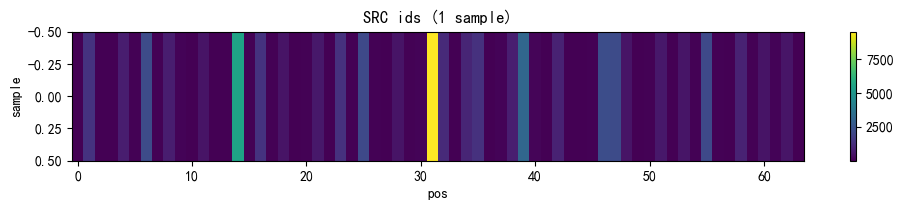

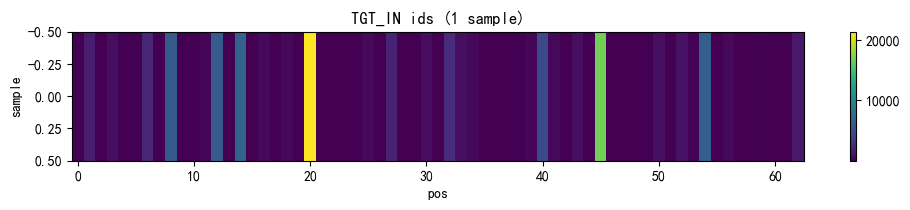

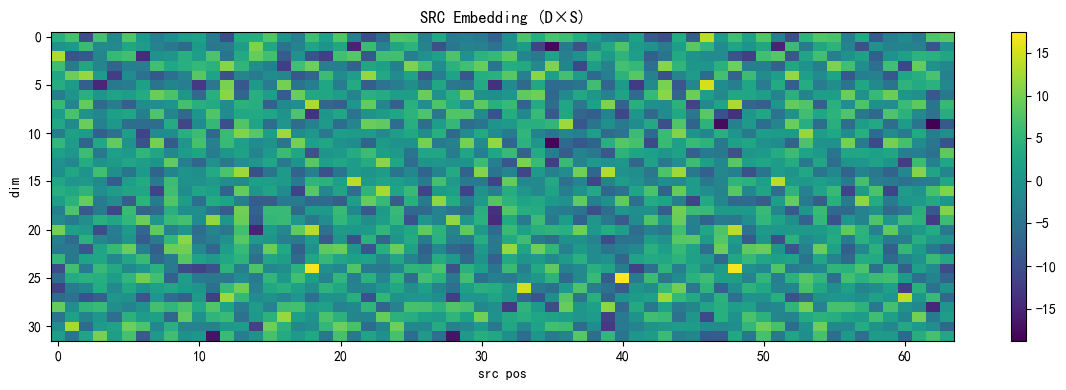

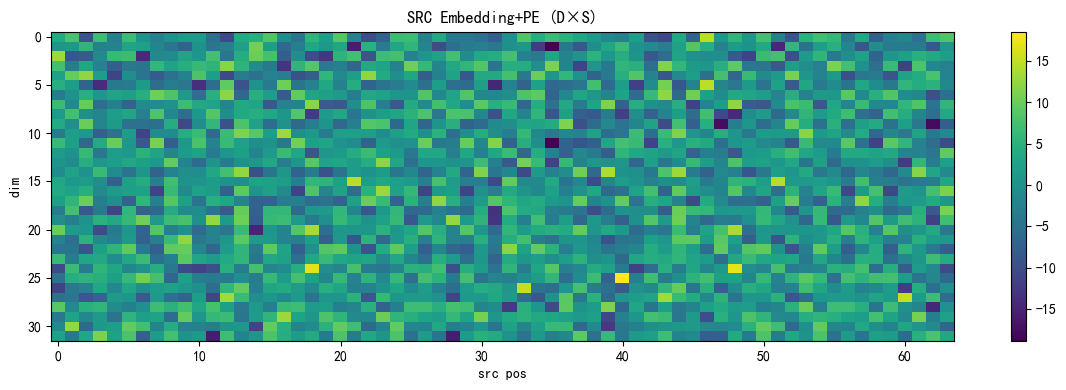

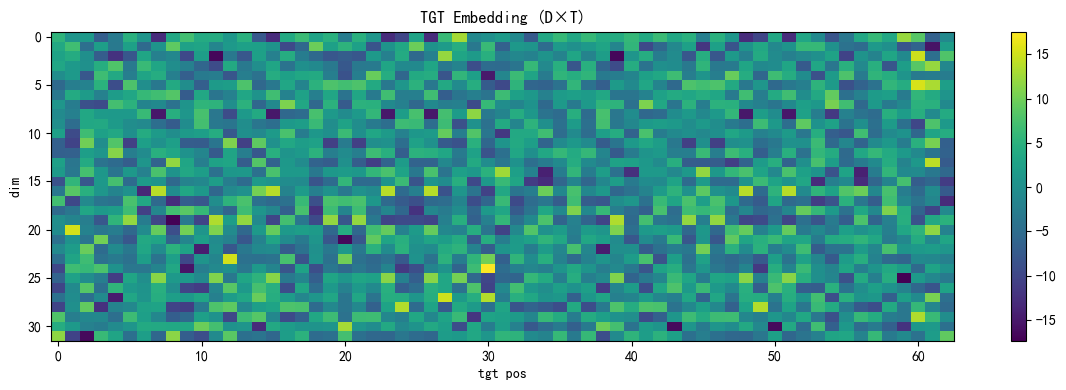

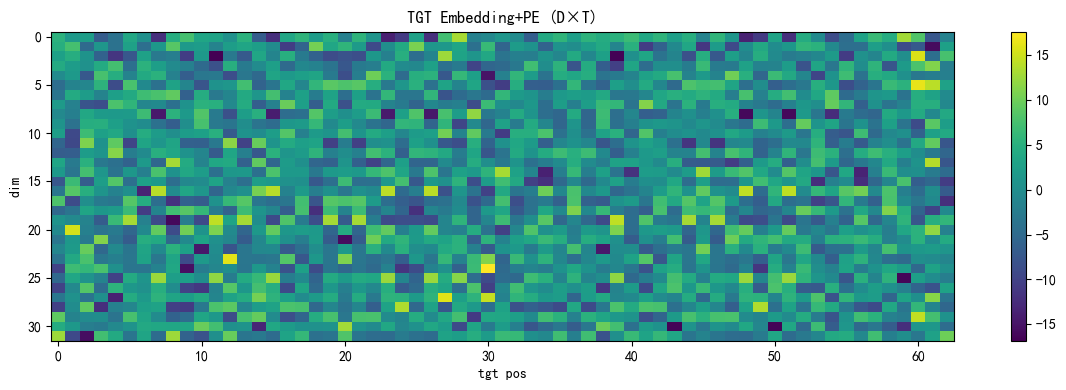

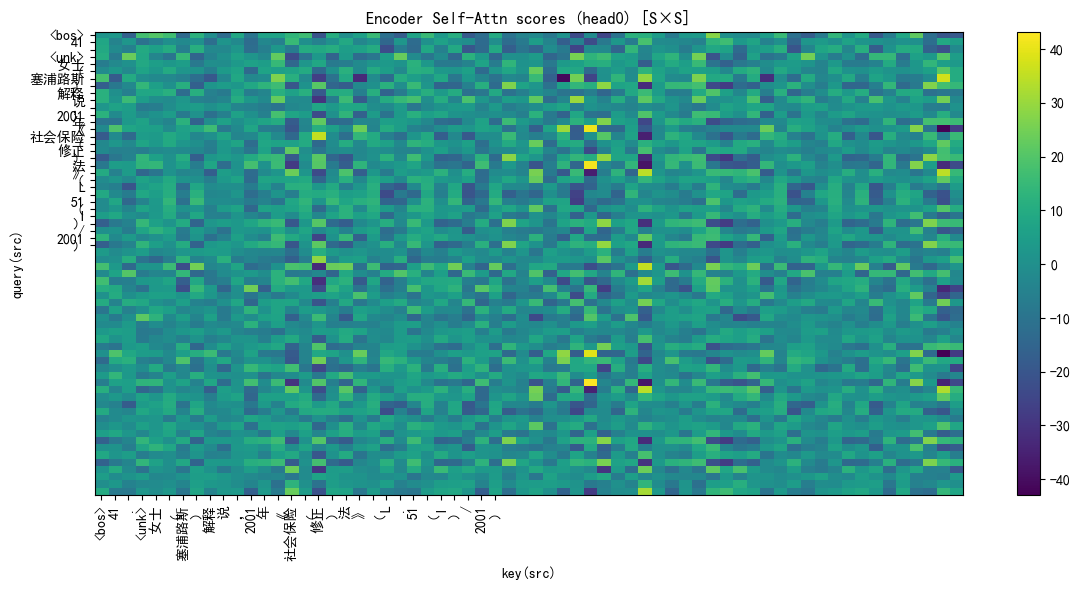

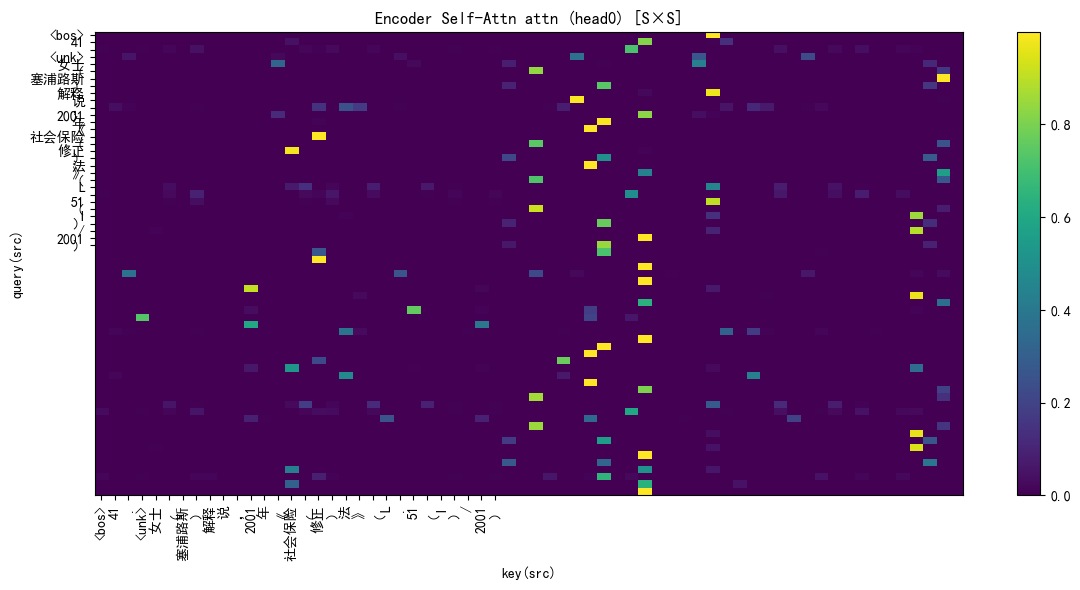

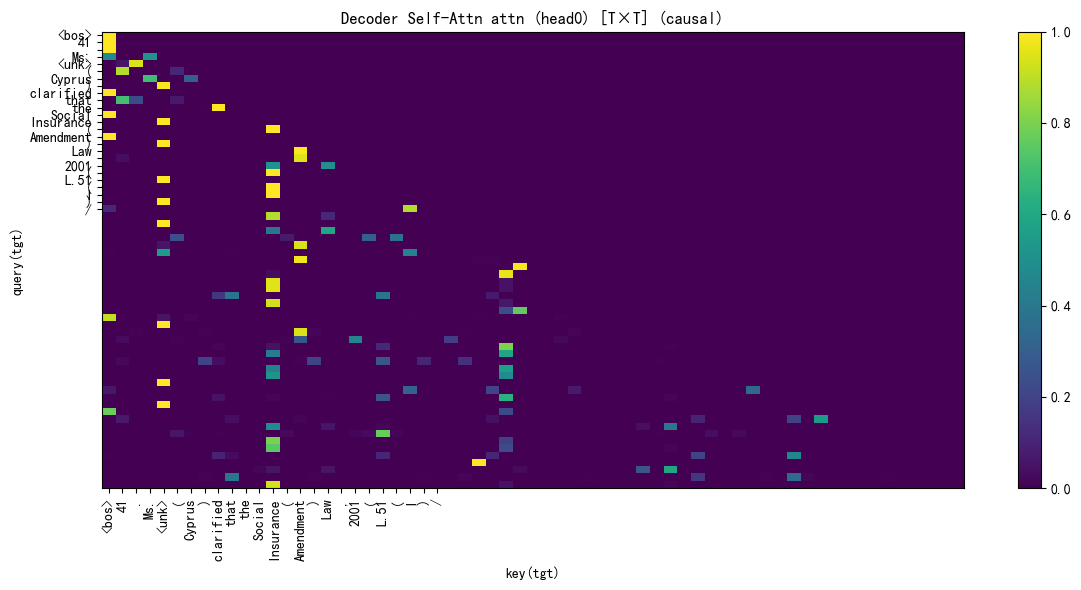

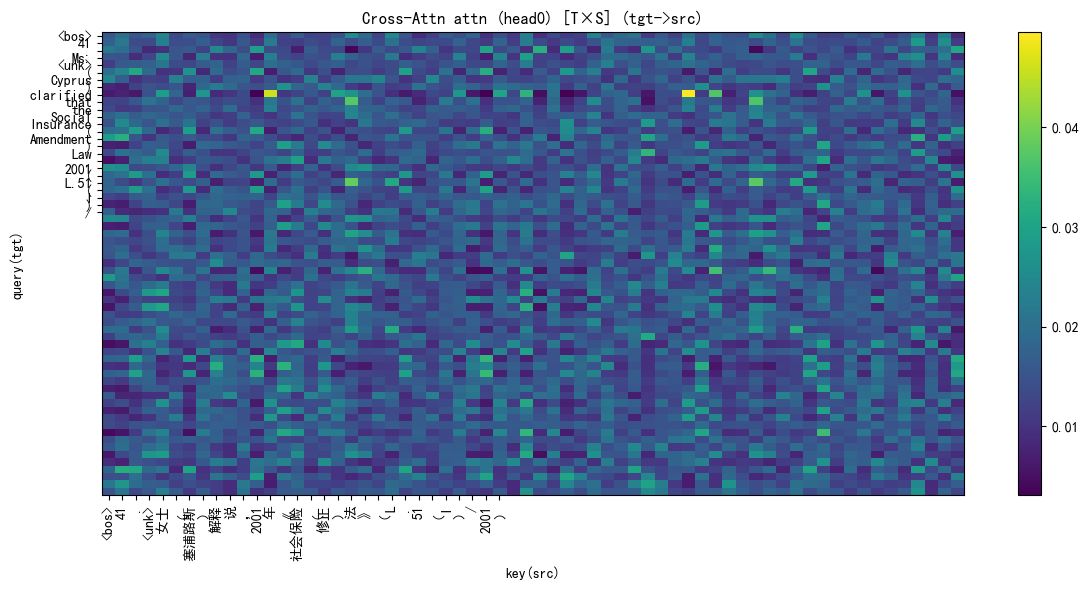

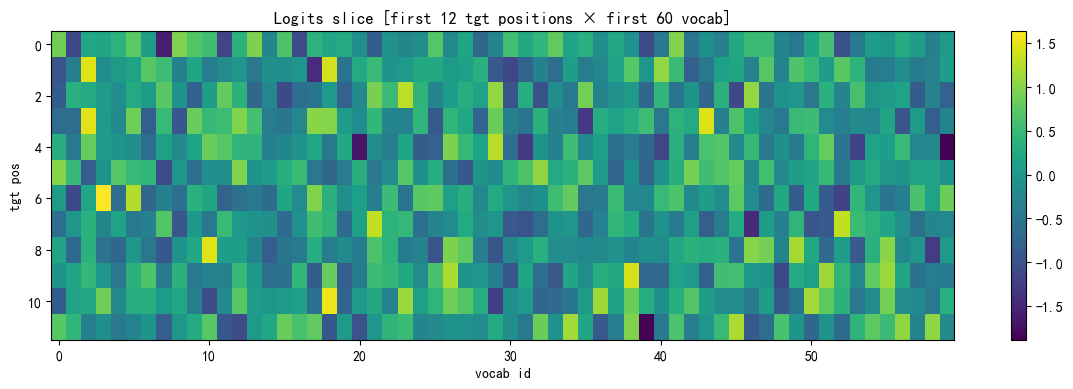

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerExplain(
    src_vocab=len(src_itos),
    tgt_vocab=len(tgt_itos),
    d_model=32, n_heads=4, d_ff=128, dropout=0.0, max_len=128  # dropout=0 更清晰
).to(device)

batch = next(iter(small_loader))

src = batch["src"].to(device)
tgt_in = batch["tgt_in"].to(device)
tgt_out = batch["tgt_out"].to(device)
src_kpm = batch["src_key_padding_mask"].to(device)
tgt_kpm = batch["tgt_key_padding_mask"].to(device)
tgt_sub = batch["tgt_sub_mask"].to(device)

with torch.no_grad():
    logits = model(src, tgt_in, src_key_padding_mask=src_kpm, tgt_key_padding_mask=tgt_kpm, tgt_sub_mask=tgt_sub)

# ===== 选择一个样本，取出 token 标签 =====
b = 0
src_ids = batch["src"][b].tolist()
tgt_ids = batch["tgt_in"][b].tolist()
src_tokens = ids_to_tokens(src_ids, src_itos)
tgt_tokens = ids_to_tokens(tgt_ids, tgt_itos)

# ===== 1) src/tgt id 矩阵 =====
heatmap(batch["src"][b:b+1, :].cpu(), title="SRC ids (1 sample)", xlab="pos", ylab="sample", figsize=(10,2.2))
heatmap(batch["tgt_in"][b:b+1, :].cpu(), title="TGT_IN ids (1 sample)", xlab="pos", ylab="sample", figsize=(10,2.2))

# ===== 2) Embedding + Positional Encoding（L×D）=====
src_emb = model.cache["src_emb"][b]   # [S,D]
src_pe  = model.cache["src_pe"][b]    # [S,D]
heatmap(src_emb.T, title="SRC Embedding (D×S)", xlab="src pos", ylab="dim", figsize=(12,4))
heatmap(src_pe.T,  title="SRC Embedding+PE (D×S)", xlab="src pos", ylab="dim", figsize=(12,4))

tgt_emb = model.cache["tgt_emb"][b]   # [T,D]
tgt_pe  = model.cache["tgt_pe"][b]    # [T,D]
heatmap(tgt_emb.T, title="TGT Embedding (D×T)", xlab="tgt pos", ylab="dim", figsize=(12,4))
heatmap(tgt_pe.T,  title="TGT Embedding+PE (D×T)", xlab="tgt pos", ylab="dim", figsize=(12,4))

# ===== 3) Encoder self-attn：scores / attn（取 head=0）=====
enc_cache = model.enc.self_attn.cache
enc_scores = enc_cache["scores"][b, 0]  # [S,S]
enc_attn   = enc_cache["attn"][b, 0]    # [S,S]
heatmap(enc_scores, title="Encoder Self-Attn scores (head0) [S×S]", xlab="key(src)", ylab="query(src)",
        xticks=src_tokens[:30], yticks=src_tokens[:30], figsize=(12,6))
heatmap(enc_attn, title="Encoder Self-Attn attn (head0) [S×S]", xlab="key(src)", ylab="query(src)",
        xticks=src_tokens[:30], yticks=src_tokens[:30], figsize=(12,6))

# ===== 4) Decoder self-attn：scores / attn（head=0，因果mask后）=====
dec_sa_cache = model.dec.self_attn.cache
dec_scores = dec_sa_cache["scores"][b, 0]  # [T,T]
dec_attn   = dec_sa_cache["attn"][b, 0]    # [T,T]
heatmap(dec_attn, title="Decoder Self-Attn attn (head0) [T×T] (causal)", xlab="key(tgt)", ylab="query(tgt)",
        xticks=tgt_tokens[:25], yticks=tgt_tokens[:25], figsize=(12,6))

# ===== 5) Cross-attn：tgt->src 对齐（head=0）=====
cross_cache = model.dec.cross_attn.cache
cross_attn = cross_cache["attn"][b, 0]  # [T,S]
heatmap(cross_attn, title="Cross-Attn attn (head0) [T×S] (tgt->src)", xlab="key(src)", ylab="query(tgt)",
        xticks=src_tokens[:30], yticks=tgt_tokens[:25], figsize=(12,6))

# ===== 6) logits：只展示一个小切片（例如前 12 个 tgt 位置，前 60 个词表）=====
logits_b = model.cache["logits"][b]  # [T,V]
heatmap(logits_b[:12, :60], title="Logits slice [first 12 tgt positions × first 60 vocab]", xlab="vocab id", ylab="tgt pos",
        figsize=(12,4))


# 训练（小样本），并把每一步的 loss 画出来 + 训练前后对比注意力

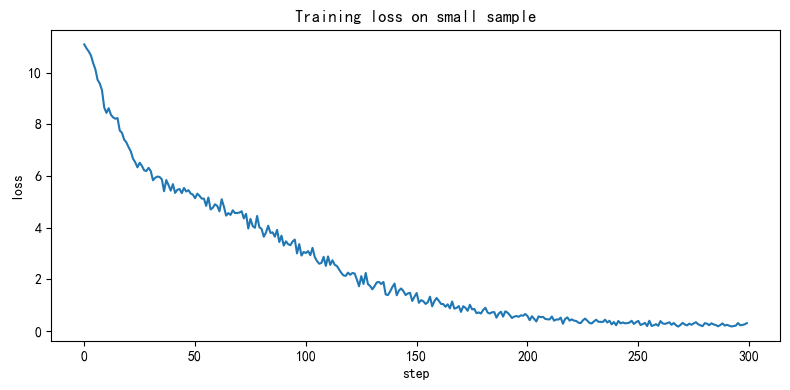

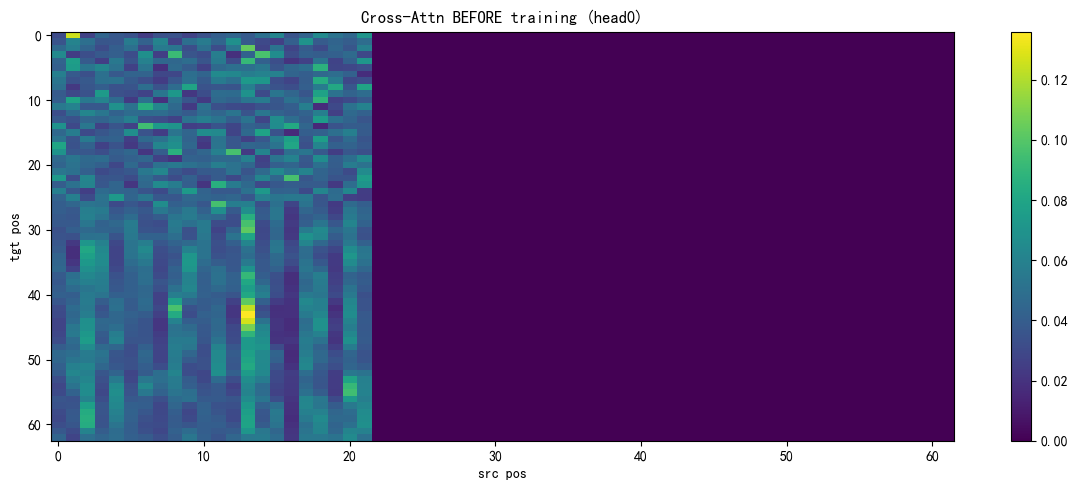

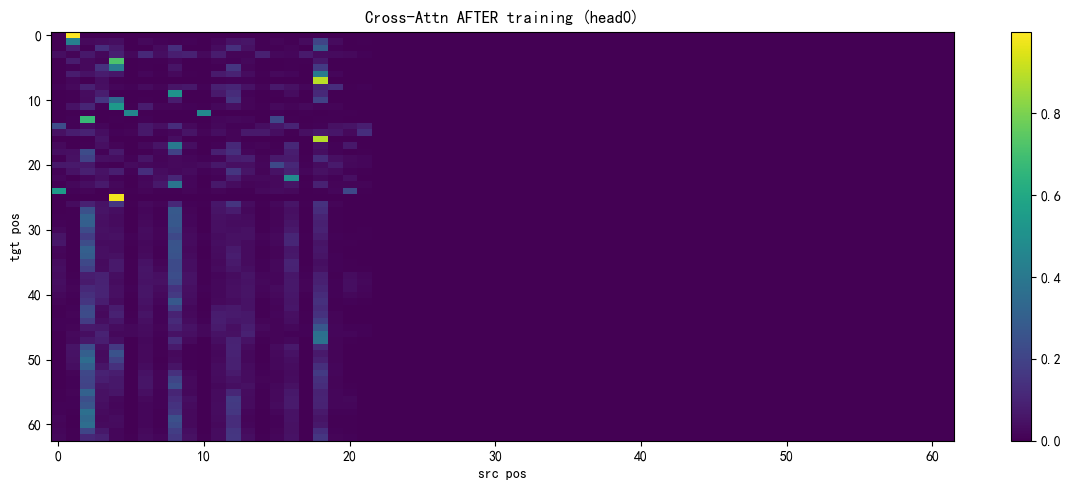

In [77]:
import torch.optim as optim
import torch.nn.functional as F

model = TransformerExplain(
    src_vocab=len(src_itos),
    tgt_vocab=len(tgt_itos),
    d_model=512, n_heads=8, d_ff=2048, dropout=0.1, max_len=512
).to(device)

optimizer = optim.Adam(model.parameters(), lr=3e-4)

def compute_loss(logits, tgt_out, pad_id=0):
    # logits: [B,T,V], tgt_out: [B,T]
    B, T, V = logits.shape
    loss = F.cross_entropy(
        logits.view(B*T, V),
        tgt_out.view(B*T),
        ignore_index=pad_id
    )
    return loss

loss_hist = []

# 训练前抓一次注意力（同一个 batch）
batch0 = next(iter(small_loader))
def run_and_get_cross_attn(model, batch, b=0, head=0):
    model.eval()
    with torch.no_grad():
        src = batch["src"].to(device)
        tgt_in = batch["tgt_in"].to(device)
        src_kpm = batch["src_key_padding_mask"].to(device)
        tgt_kpm = batch["tgt_key_padding_mask"].to(device)
        tgt_sub = batch["tgt_sub_mask"].to(device)
        _ = model(src, tgt_in, src_key_padding_mask=src_kpm, tgt_key_padding_mask=tgt_kpm, tgt_sub_mask=tgt_sub)
    return model.dec.cross_attn.cache["attn"][b, head].detach().cpu()

attn_before = run_and_get_cross_attn(model, batch0, b=0, head=0)

# ===== 训练若干步 =====
model.train()
steps = 300
it = iter(small_loader)

for step in range(steps):
    try:
        batch = next(it)
    except StopIteration:
        it = iter(small_loader)
        batch = next(it)

    src = batch["src"].to(device)
    tgt_in = batch["tgt_in"].to(device)
    tgt_out = batch["tgt_out"].to(device)
    src_kpm = batch["src_key_padding_mask"].to(device)
    tgt_kpm = batch["tgt_key_padding_mask"].to(device)
    tgt_sub = batch["tgt_sub_mask"].to(device)

    optimizer.zero_grad()
    logits = model(src, tgt_in, src_key_padding_mask=src_kpm, tgt_key_padding_mask=tgt_kpm, tgt_sub_mask=tgt_sub)
    loss = compute_loss(logits, tgt_out, pad_id=PAD_ID)
    loss.backward()
    optimizer.step()

    loss_hist.append(loss.item())

# loss 曲线
plt.figure(figsize=(8,4))
plt.plot(loss_hist)
plt.title("Training loss on small sample")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
plt.show()

# 训练后再抓一次注意力（同一个 batch0）
attn_after = run_and_get_cross_attn(model, batch0, b=0, head=0)

# 对比前后 cross-attn
heatmap(attn_before, title="Cross-Attn BEFORE training (head0)", xlab="src pos", ylab="tgt pos", figsize=(12,5))
heatmap(attn_after,  title="Cross-Attn AFTER training (head0)",  xlab="src pos", ylab="tgt pos", figsize=(12,5))
